- This notebook allows to compute the intrinsic alignment signal $w_{g+}$ of galaxies (projected 2D estimator) from a given survey
- Data : UNIONS shape catalogue matched with CMASS galaxy positions


In [238]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import linalg
from scipy.spatial import cKDTree
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d

from astropy.io import fits
from astropy.table import Table, Column
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import z_at_value
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.coordinates import concatenate
from astropy import units as u

from matplotlib.patches import Ellipse
from scipy.spatial.transform import Rotation

import treecorr
import random

import torch
from torch.distributions import Uniform

from sbi.utils import BoxUniform
from sbi.analysis import pairplot
from sbi.inference import NPE, SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
    prepare_for_sbi
)

from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import BallTree

import math
import os

from scipy.ndimage import gaussian_filter
import time, glob

In [227]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [228]:
# Function required for further work 

def get_galaxy_orientation_angle(e1,e2):
    return 0.5*np.arctan2(e2,e1)

def abs_e(e1,e2):
    return np.sqrt(e1*e1+e2*e2)

def a_b(e1,e2):
    e = abs_e(e1,e2)
    return 1+e,1-e  

def e_complex(a,b,r):
    abs_e = (1-(b/a)) / (1+(b/a))
    e1 = abs_e*np.cos(2*r)
    e2 = abs_e*np.sin(2*r)
    return e1, e2

In [243]:
# Galaxy catalogues

unions_lrg_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/code/projet_stage/sbi/unions_lrg_cross.fits')

names = [name for name in unions_lrg_table.colnames if len(unions_lrg_table[name].shape) <= 1]
filtered_tbl = unions_lrg_table[names]

unions_lrg = filtered_tbl.to_pandas()
unions_lrg.columns


nb_unions_lrg = len(unions_lrg)

unions_lrg_index = unions_lrg.index
unions_lrg_index=np.array(unions_lrg_index)





unions_lrg_table2 = Table.read('/Users/antonincorinaldi/Documents/stage césure/code/projet_stage/sbi/unions_lrg_cross2.fits')

names = [name for name in unions_lrg_table2.colnames if len(unions_lrg_table2[name].shape) <= 1]
filtered_tbl = unions_lrg_table2[names]

unions_lrg2 = filtered_tbl.to_pandas()
unions_lrg2.columns


nb_unions_lrg2 = len(unions_lrg2)

unions_lrg_index2 = unions_lrg2.index
unions_lrg_index2=np.array(unions_lrg_index2)





chi = cosmo.comoving_distance(unions_lrg2['Z'] ).value


x = chi * np.cos(unions_lrg['RA'].values * np.pi/180) * np.cos(unions_lrg['Dec'].values * np.pi/180)
y = chi * np.sin(unions_lrg['RA'].values * np.pi/180) * np.cos(unions_lrg['Dec'].values * np.pi/180) 
z = chi * np.sin(unions_lrg['Dec'].values * np.pi/180)


positions = np.vstack([x, y, z]).T


e1 = unions_lrg['e1'].values ; e2 = unions_lrg['e2'].values
#e1 = np.average(e1, weights=unions_lrg['w_iv'].values) ; e2 = np.average(e2, weights=unions_lrg['w_iv'].values)

In [250]:
cmass_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/code/projet_stage/sbi/unions_cmass_cross.fits')

names = [name for name in cmass_table.colnames if len(cmass_table[name].shape) <= 1]
filtered_tbl = cmass_table[names]

unions_cmass = filtered_tbl.to_pandas()
unions_cmass.columns





cmass_table2 = Table.read('/Users/antonincorinaldi/Documents/stage césure/code/projet_stage/sbi/unions_cmass_cross2.fits')

names = [name for name in cmass_table2.colnames if len(cmass_table2[name].shape) <= 1]
filtered_tbl = cmass_table2[names]

unions_cmass2 = filtered_tbl.to_pandas()
unions_cmass2.columns





chi = cosmo.comoving_distance(unions_cmass2['Z'] ).value


x = chi * np.cos(unions_cmass['RA'].values * np.pi / 180) * np.cos(unions_cmass['Dec'].values * np.pi / 180)
y = chi * np.sin(unions_cmass['RA'].values * np.pi / 180) * np.cos(unions_cmass['Dec'].values * np.pi / 180)
z = chi * np.sin(unions_cmass['Dec'].values * np.pi / 180)

positions = np.vstack((x, y, z)).T 



e1 = unions_cmass['e1'].values ; e2 = unions_cmass['e2'].values

w = unions_cmass['w_iv'].values
# e1 = np.average(e1, weights=unions_cmass['w_iv'].values) ; e2 = np.average(e2, weights=unions_cmass['w_iv'].values)

In [251]:
def get_angles(ra1, dec1, ra2, dec2, u_coords='deg'):
    
    c1 = SkyCoord(ra1, dec1, unit=u_coords, frame='icrs', equinox='J2000.0')
    c2 = SkyCoord(ra2, dec2, unit=u_coords, frame='icrs', equinox='J2000.0')
    theta = c1.position_angle(c2)

    A = np.cos(dec2) * np.sin(dec1)
    B = np.cos(ra2 - ra1) * np.sin(dec2) * np.cos(dec1)
    C = np.sin(theta)
    
    phi = np.arcsin((A-B)/C)

    return phi.value, theta.value

In [248]:
tree = BallTree(positions, leaf_size=40, metric='euclidean')


rp_bins = np.linspace(0, 60, 20) ; pi_bins = np.linspace(-60, 60, 50)  


max_sep = np.sqrt(60**2 + 60**2)


indices = tree.query_radius(positions, r=max_sep)


pairs = np.array([(i, j) for i, neighbors in enumerate(indices) for j in neighbors if j != i])


i_indices = pairs[:,0] ; j_indices = pairs[:,1]


pi = chi[j_indices] - chi[i_indices]


chi12 = np.linalg.norm(positions[j_indices] - positions[i_indices], axis=1)


phi, theta = get_angles(
    unions_lrg['RA'].values[i_indices], unions_lrg['Dec'].values[i_indices],
    unions_lrg['RA'].values[j_indices], unions_lrg['Dec'].values[j_indices],
    u_coords='deg'
)


rp = np.sqrt(chi12**2 - pi**2)


pairs = np.column_stack((i_indices, j_indices, rp, pi, phi))

/opt/homebrew/lib/python3.12/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in arcsin
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [252]:
tree = BallTree(positions, leaf_size=40, metric='euclidean')

rp_bins = np.linspace(0, 60, 20) ; pi_bins = np.linspace(-60, 60, 50)  

max_sep = np.sqrt(60**2 + 60**2)

indices = tree.query_radius(positions, r=max_sep)

pairs = np.array([(i, j) for i, neighbors in enumerate(indices) for j in neighbors if j != i])

i_indices = pairs[:, 0] ; j_indices = pairs[:, 1]

pi = chi[j_indices] - chi[i_indices]

chi12 = np.linalg.norm(positions[j_indices] - positions[i_indices], axis=1)

phi, theta = get_angles(
    unions_cmass['RA'].values[i_indices], unions_cmass['Dec'].values[i_indices],
    unions_cmass['RA'].values[j_indices], unions_cmass['Dec'].values[j_indices],
    u_coords='deg'
)

rp = np.sqrt(chi12**2 - pi**2)

pairs = np.column_stack((i_indices, j_indices, rp, pi, phi))

/opt/homebrew/lib/python3.12/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in arcsin
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


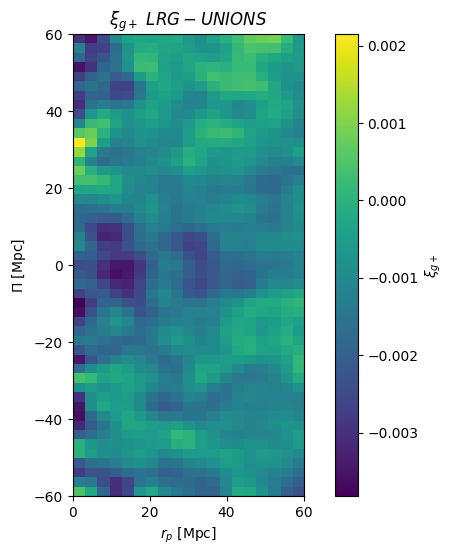

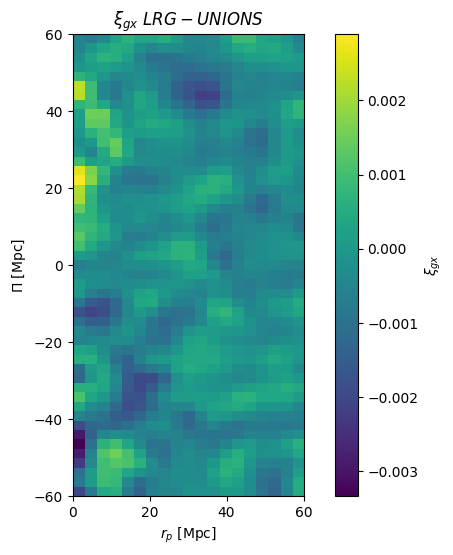

In [178]:
# e_t

rp_values = pairs[:, 2] ; pi_values = pairs[:, 3] ; angle_values = pairs[:, 4] ; e1_values = e1[j_indices] ; e2_values = e2[j_indices]


e_tangential = - e1_values * np.cos(2 * angle_values) - e2_values * np.sin(2 * angle_values)

e_cross = e1_values * np.sin(2 * angle_values) - e2_values * np.cos(2 * angle_values)


valid = ~np.isnan(e_tangential)
rp_values = rp_values[valid]
pi_values = pi_values[valid]
e_tangential = e_tangential[valid]


stat, x_edge, y_edge, binnumber = binned_statistic_2d(
    rp_values, pi_values, e_tangential, statistic='mean', bins=[rp_bins, pi_bins]
)

stat_lrg = gaussian_filter(stat, sigma=1)



plt.figure(figsize=(8, 6))
plt.imshow(stat_lrg.T, origin='lower', extent=[0, 60, -60, 60])
plt.colorbar(label=r'$\xi_{g+}$')
plt.xlabel(r'$r_p$ [Mpc]')
plt.ylabel(r'$\Pi$ [Mpc]')
plt.title(r'$\xi_{g+}~LRG-UNIONS$')
plt.show()








# e_x

rp_values = pairs[:, 2] ; pi_values = pairs[:, 3] ; angle_values = pairs[:, 4] ; e1_values = e1[j_indices] ; e2_values = e2[j_indices]


e_cross = e1_values * np.sin(2 * angle_values) - e2_values * np.cos(2 * angle_values)


valid = ~np.isnan(e_cross)
rp_values = rp_values[valid]
pi_values = pi_values[valid]
e_cross = e_cross[valid]


stat2, x_edge, y_edge, binnumber = binned_statistic_2d(
    rp_values, pi_values, e_cross, statistic='mean', bins=[rp_bins, pi_bins]
)

stat2_lrg = gaussian_filter(stat2, sigma=1)


plt.figure(figsize=(8, 6))
plt.imshow(stat2_lrg.T, origin='lower', extent=[0, 60, -60, 60])
plt.colorbar(label=r'$\xi_{gx}$')
plt.xlabel(r'$r_p$ [Mpc]')
plt.ylabel(r'$\Pi$ [Mpc]')
plt.title(r'$\xi_{gx}~LRG-UNIONS$')
plt.show()

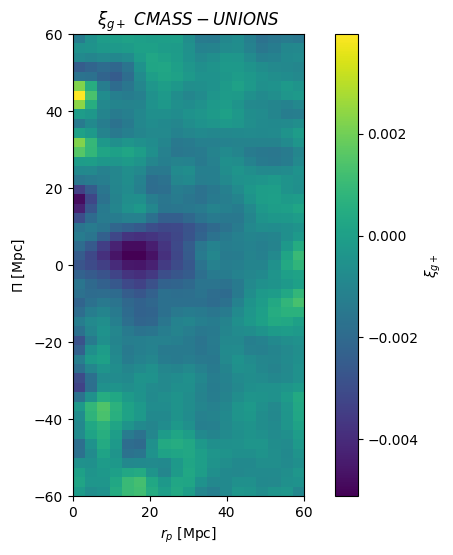

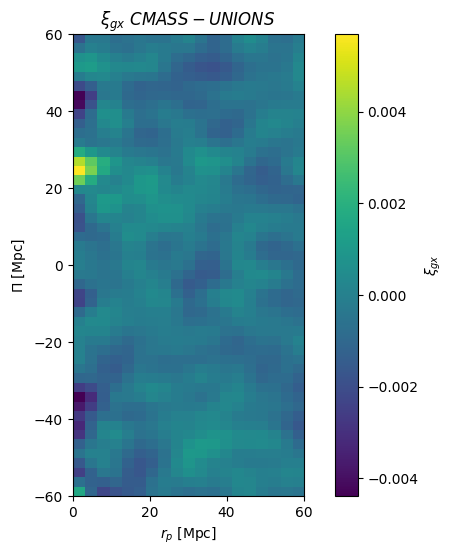

In [253]:
# e_t

rp_values = pairs[:, 2] ; pi_values = pairs[:, 3] ; angle_values = pairs[:, 4] ; e1_values = e1[j_indices] ; e2_values = e2[j_indices] ; weights = w[j_indices]


e_tangential = - e1_values * np.cos(2 * angle_values) - e2_values * np.sin(2 * angle_values)
e_cross = e1_values * np.sin(2 * angle_values) - e2_values * np.cos(2 * angle_values)


valid = ~np.isnan(e_tangential)
rp_values = rp_values[valid]
pi_values = pi_values[valid]
e_tangential = e_tangential[valid]
weights = weights[valid]


weighted_sum, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, e_tangential * weights, statistic='sum', bins=[rp_bins, pi_bins]
)

weight_sum, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, weights, statistic='sum', bins=[rp_bins, pi_bins]
)


stat_weighted = np.divide(weighted_sum, weight_sum, out=np.zeros_like(weighted_sum), where=weight_sum != 0)


stat_cmass = gaussian_filter(stat_weighted, sigma=1)



plt.figure(figsize=(8, 6))
plt.imshow(stat_cmass.T, origin='lower', extent=[0, 60, -60, 60])
plt.colorbar(label=r'$\xi_{g+}$')
plt.xlabel(r'$r_p$ [Mpc]')
plt.ylabel(r'$\Pi$ [Mpc]')
plt.title(r'$\xi_{g+}~CMASS-UNIONS$')
plt.show()








# e_x

rp_values = pairs[:, 2] ; pi_values = pairs[:, 3] ; angle_values = pairs[:, 4] ; e1_values = e1[i_indices] ; e2_values = e2[i_indices] ; weights = w[j_indices]


e_cross = e1_values * np.sin(2 * angle_values) - e2_values * np.cos(2 * angle_values)


valid = ~np.isnan(e_cross)
rp_values = rp_values[valid]
pi_values = pi_values[valid]
e_cross = e_cross[valid]
weights = weights[valid]


weighted_sum, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, e_cross * weights, statistic='sum', bins=[rp_bins, pi_bins]
)

weight_sum, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, weights, statistic='sum', bins=[rp_bins, pi_bins]
)


stat_weighted = np.divide(weighted_sum, weight_sum, out=np.zeros_like(weighted_sum), where=weight_sum != 0)


stat2_cmass = gaussian_filter(stat_weighted, sigma=1)


plt.figure(figsize=(8, 6))
plt.imshow(stat2_cmass.T, origin='lower', extent=[0, 60, -60, 60])
plt.colorbar(label=r'$\xi_{gx}$')
plt.xlabel(r'$r_p$ [Mpc]')
plt.ylabel(r'$\Pi$ [Mpc]')
plt.title(r'$\xi_{gx}~CMASS-UNIONS$')
plt.show()

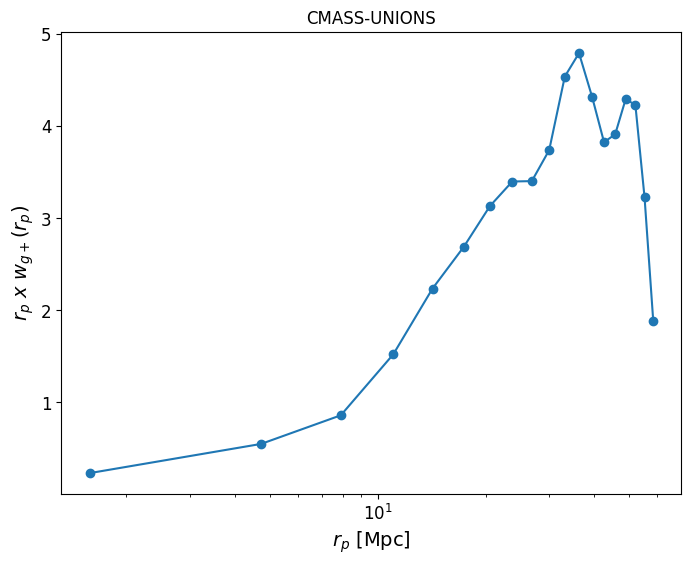

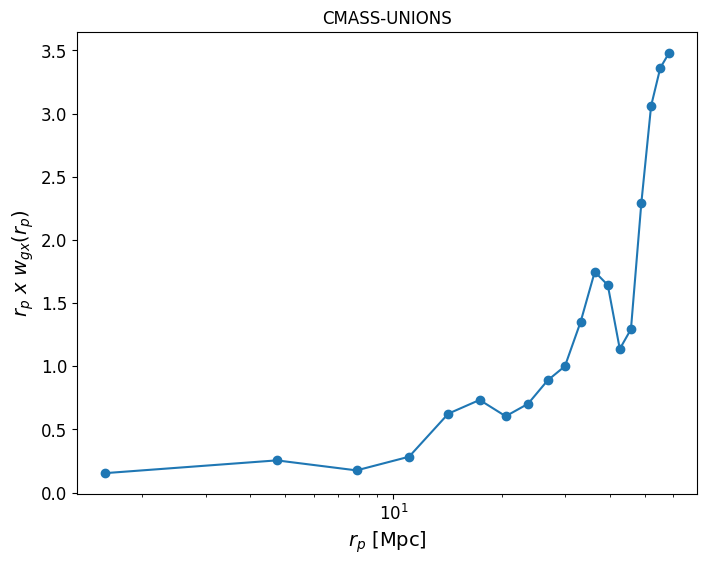

In [234]:
delta_pi = pi_bins[1] - pi_bins[0]  
wg_plus = np.nansum(stat_cmass, axis=1) * delta_pi 


rp_bin_centers = 0.5 * (rp_bins[1:] + rp_bins[:-1])


rp_times_wg_plus = rp_bin_centers * wg_plus


plt.figure(figsize=(8, 6))
plt.plot(rp_bin_centers, -rp_times_wg_plus, marker='o')
plt.xscale('log')
plt.xlabel(r'$r_p$ [Mpc]',fontsize=14)
plt.ylabel(r'$r_p~x~w_{g+}(r_p)$',fontsize=14)
plt.title("CMASS-UNIONS")
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()





delta_pi = pi_bins[1] - pi_bins[0]  
wg_cross = np.nansum(stat2_cmass, axis=1) * delta_pi 


rp_bin_centers = 0.5 * (rp_bins[1:] + rp_bins[:-1])


rp_times_wg_cross = rp_bin_centers * wg_cross


plt.figure(figsize=(8, 6))
plt.plot(rp_bin_centers, -rp_times_wg_cross, marker='o')
plt.xscale('log')
plt.xlabel(r'$r_p$ [Mpc]',fontsize=14)
plt.ylabel(r'$r_p~x~w_{gx}(r_p)$',fontsize=14)
plt.title("CMASS-UNIONS")
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

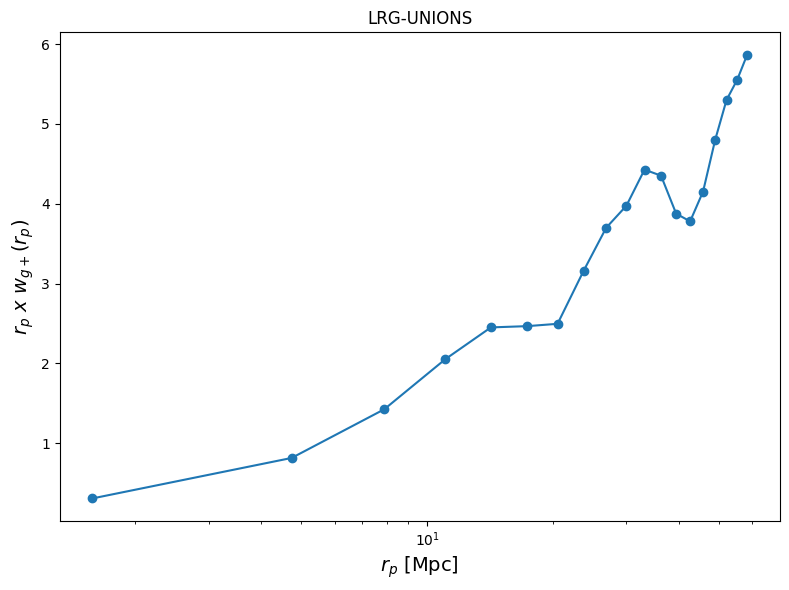

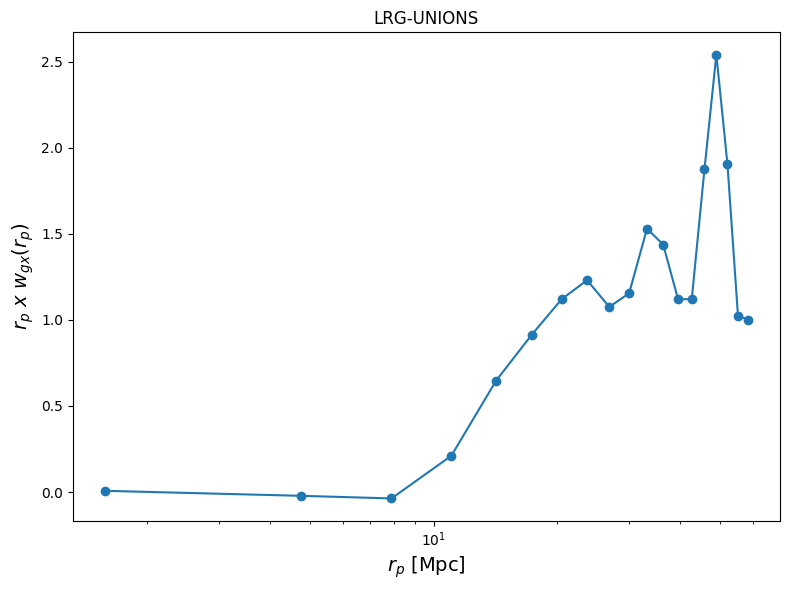

In [224]:
delta_pi = pi_bins[1] - pi_bins[0]  
wg_plus = np.nansum(stat_lrg, axis=1) * delta_pi 


rp_bin_centers = 0.5 * (rp_bins[1:] + rp_bins[:-1])


rp_times_wg_plus = rp_bin_centers * wg_plus


plt.figure(figsize=(8, 6))
plt.plot(rp_bin_centers, -rp_times_wg_plus, marker='o')
plt.xscale('log')
plt.xlabel(r'$r_p$ [Mpc]',fontsize=14)
plt.ylabel(r'$r_p~x~w_{g+}(r_p)$',fontsize=14)
plt.title("LRG-UNIONS")
plt.tight_layout()
plt.show()





delta_pi = pi_bins[1] - pi_bins[0]  
wg_cross = np.nansum(stat2_lrg, axis=1) * delta_pi 


rp_bin_centers = 0.5 * (rp_bins[1:] + rp_bins[:-1])


rp_times_wg_cross = rp_bin_centers * wg_cross


plt.figure(figsize=(8, 6))
plt.plot(rp_bin_centers, -rp_times_wg_cross, marker='o')
plt.xscale('log')
plt.xlabel(r'$r_p$ [Mpc]',fontsize=14)
plt.ylabel(r'$r_p~x~w_{gx}(r_p)$',fontsize=14)
plt.title("LRG-UNIONS")
plt.tight_layout()
plt.show()

In [28]:
# Compute positions

chi = cosmo.comoving_distance(unions_lrg2['Z'] ).value


x = chi * np.cos(unions_lrg['RA'].values * np.pi / 180) * np.cos(unions_lrg['Dec'].values * np.pi / 180)
y = chi * np.sin(unions_lrg['RA'].values * np.pi / 180) * np.cos(unions_lrg['Dec'].values * np.pi / 180)
z = chi * np.sin(unions_lrg['Dec'].values * np.pi / 180)

positions = np.vstack((x, y, z)).T 



unions_lrg3 = Table()
unions_lrg3['x_L2com'] = positions

In [286]:
unions_lrg3['RA'] = unions_lrg['RA']
unions_lrg3['Dec'] = unions_lrg['Dec']
unions_lrg3['e1'] = unions_lrg['e1']
unions_lrg3['e2'] = unions_lrg['e2']

In [287]:
# Redshift 

unions_lrg3['Z'] = unions_lrg2['Z']

In [288]:
# Weights

unions_lrg3['WEIGHT_SYS'] = unions_lrg2['WEIGHT_SYS']
unions_lrg3['WEIGHT_ZFAIL'] = unions_lrg2['WEIGHT_ZFAIL']

In [289]:
unions_lrg3

x_L2com,RA,Dec,e1,e2,Z,WEIGHT_SYS,WEIGHT_ZFAIL
float64[3],float64,float64,float64,float64,float64,float64,float64
-462.17168108096615 .. 2500.748445077318,107.4110053002635,58.298781994102185,0.09726718221512481,-0.043858931532465166,0.8563422092208347,0.9709813594818115,1.0007710456848145
-365.7833031564073 .. 2023.2854409389508,107.02292158987348,58.303104640166346,-0.01502569139992249,-0.022120575579898622,0.6565985839368313,0.9955649971961975,1.0
-478.65678309166316 .. 2517.9832045427647,107.54144161315023,57.759670987369994,-1.3671836737001123e-07,-0.0031831186788059537,0.870644642297436,0.9701884388923645,1.0021969079971313
-282.2003766507877 .. 1464.195372863177,107.79734873119818,57.76575353400219,-0.10901782107947693,-0.02551412125666543,0.45250300627855294,0.9463997483253479,1.0
-348.4540798968277 .. 1852.328541099595,107.36309109827067,57.77417826646897,-0.04169051221129839,-0.182083239084395,0.5945819100629426,0.9484668374061584,1.0002044439315796
-323.2990427278886 .. 1710.4539303977474,107.47151088130252,57.80714762751813,0.5123453881889926,-0.37305330616178234,0.5410008550333499,0.9484668374061584,1.0001888275146484
-449.92207958835627 .. 2384.6943530351864,107.4466164298422,57.818358279858636,0.24823414046317444,0.1483189349901954,0.8109647183997104,0.9701884388923645,1.0009959936141968
-386.66583650572585 .. 2019.4403447659085,107.71868256832082,57.824765223575554,0.02392389908929655,0.027122386592058276,0.6592386769028862,0.9937735795974731,1.000097632408142
-341.6723762390691 .. 1851.3546264804827,107.13509135472019,57.937093145146385,0.2295743140485336,-0.04758571219291455,0.5929477915446572,0.9542621970176697,1.0


In [290]:
# Functions required to compute intrinsic alignments of galaxies


def get_points(data):
    '''convert from astropy table of RA and DEC to cartesian coordinates on a unit sphere'''
    points = SkyCoord(data['RA'], data['Dec'], unit='deg', frame='icrs', equinox='J2000.0')
    points = points.cartesian   # old astropy: points.representation = 'cartesian'
    return np.dstack([points.x.value, points.y.value, points.z.value])[0]

def deg_to_rad(ang_deg):
    return ang_deg * np.pi / 180

def get_Mpc_h(deg, z=0.725):
    return deg_to_rad(deg) * (cosmo.angular_diameter_distance(z)/u.Mpc) / 0.7 # in units of Mpc/h, assuming lcdm and z=0.725


def remove_astropyu(values_list, unit=u.Mpc):
    if isinstance(values_list[0], u.Quantity):
        return [v.to(u.Mpc).value for v in values_list]
    else:
        return values_list
    
    
        

def get_pa(ra1, dec1, ra2, dec2, u_coords='deg', u_result=u.rad):
    '''
    Input: ra and decs [deg] for two objects. 
    Returns: 
    - separation [deg]
    - astropy quantity of position angle of second galaxy relative to first [deg], E of N
    '''
    c1 = SkyCoord(ra1, dec1, unit=u_coords, frame='icrs', equinox='J2000.0')
    c2 = SkyCoord(ra2, dec2, unit=u_coords, frame='icrs', equinox='J2000.0')
    pa = c1.position_angle(c2).to(u_result)

    return pa


def get_psep(ra1, dec1, ra2, dec2, u_coords='deg', u_result=u.rad):
    '''
    Input: ra and decs [deg] for two objects. 
    Returns: 
    - astropy quantity of separation 
    '''
    c1 = SkyCoord(ra1, dec1, unit=u_coords, frame='icrs', equinox='J2000.0')
    c2 = SkyCoord(ra2, dec2, unit=u_coords, frame='icrs', equinox='J2000.0')
    return (c1.separation(c2)).to(u_result).value


def get_proj_dist_abacus(cat1, cat2, pos_obs=np.asarray([-3700, 0, 0])*.7):
    '''
    Returns transverse projected distance of two cartesian positions given observer position. 
    Input:
        cat1: astropy table with keys 'x_L2com', 'y_L2com', 'z_L2com'
        cat2: astropy table with keys 'x_L2com', 'y_L2com', 'z_L2com'
        pos_obs: cartesian position of observer. default is [-3700, 0, 0] Mpc/h
    returns in same units as given. default is Mpc/h
    '''
    pos_diff = cat2['x_L2com'] - cat1['x_L2com']
    pos_mid = .5 * (cat2['x_L2com'] + cat1['x_L2com'])
    obs_vec = pos_mid - pos_obs
    
    # project separation vector between objects onto LOS vector
    proj = np.sum(pos_diff*obs_vec, axis=1) / np.linalg.norm(obs_vec, axis=1)
    proj_v = (proj[:, np.newaxis] * obs_vec) / np.linalg.norm(obs_vec, axis=1)[:, np.newaxis]

    # subtract this vector from the separation vector
    # magnitude is projected transverse distance
    transverse_v = pos_diff - proj_v
    return np.linalg.norm(transverse_v, axis=1)


def get_pair_distances(catalog, indices, pos_obs=np.asarray([-3700, 0, 0])*.7, cartesian=False, use_RSD=False):
    '''
    Calculate distances between input pairs, coordinates in Mpc/h
    -------------------------------------------------------------
    Input:
        catalog: astropy table with keys 'x_L2com', 'y_L2com', 'z_L2com'
        indices: array of indices for n centers and maximum m neighbors each- shape(n,m)
        corresponding to place in catalog
    Returns (for cartesian=False):        
        r_projected: projected distance between centers and neighbors
        r_parallel: LOS distance between centers and neighbors
        s_parallel: LOS distance between centers and neighbors, with RSD
    Returns (for cartesian=True):
        deltax: x distance between centers and neighbors    
        deltayz: yz distance between centers and neighbors
    '''
    # indices in catalog of centers and neighbors, arranges so each array is same shape
    ci = np.repeat(indices[:,0], (len(indices[0])-1)).ravel() # indices of centers
    ni = indices[:,1:].ravel()   # indices of neighbors
    
    # removing places where no neighbor was found in the tree
    neighbor_exists = (ni!=len(catalog))
    ci = ci[neighbor_exists]; ni = ni[neighbor_exists]
    
    centers_m = catalog[ci]
    neighbors_m = catalog[ni]   # excluding the centers
    
    if cartesian==False:
        r_projected = get_proj_dist_abacus(centers_m, neighbors_m, pos_obs)

        if use_RSD == False:
            r_parallel = (np.abs(cosmo.comoving_distance(centers_m['Z']) - cosmo.comoving_distance(neighbors_m['Z'])) * 0.7 / u.Mpc).value
            return r_projected, r_parallel
        else:
            r_parallel = (np.abs(cosmo.comoving_distance(centers_m['Z_noRSD']) - cosmo.comoving_distance(neighbors_m['Z_noRSD'])) * 0.7 / u.Mpc).value
            s_parallel = (np.abs(cosmo.comoving_distance(centers_m['Z_withRSD']) - cosmo.comoving_distance(neighbors_m['Z_withRSD'])) * 0.7 / u.Mpc).value
            return r_projected, r_parallel, s_parallel
    
    elif cartesian==True:
        deltax = np.abs(centers_m['x_L2com'][::,0] - neighbors_m['x_L2com'][::,0])
        deltayz = np.sqrt((centers_m['x_L2com'][::,1] - neighbors_m['x_L2com'][::,1])**2 + (centers_m['x_L2com'][::,2] - neighbors_m['x_L2com'][::,2])**2)
        return deltax, deltayz
    

def get_rel_es(catalog, indices, data_weights=None, weights=None, rcolor='rw1', return_sep=True, j=0):
    '''
    input: 
        array of indices for n centers and maximum m neighbors each- shape(n,m)
        corresponding to place in catalog
        first element of each row is indic of center
        shape can be 'ser', 'dev', or 'exp' for fit used to get ellipticity components
        data_weights must be same length as catalog, with each indice corresponding to right row
    returns: 
        array of same shape, containing ellipticities relative to separation
        vector between given neighbor and it's central galaxy
    '''
    
    # indices in catalog of centers and neighbors, arranges so each array is same shape
    ci = np.repeat(indices[:,0], (len(indices[0])-1)).ravel() # indices of centers
    ni = indices[:,1:].ravel()   # indices of neighbors
    
    # removing places where no neighbor was found in the tree
    neighbor_exists = (ni!=len(catalog))
    ci = ci[neighbor_exists]; ni = ni[neighbor_exists]
    
    centers_m = catalog[ci]
    neighbors_m = catalog[ni]   # excluding the centers
    
    # get position angle
    pa = get_pa(centers_m['RA'], centers_m['Dec'], neighbors_m['RA'], neighbors_m['Dec'])
    
    
    # calculate rotation angle of neighbor relative to the separation vector
    theta_neighbor = get_galaxy_orientation_angle(neighbors_m['e1'], neighbors_m['e2'])
    a, b = a_b(neighbors_m['e1'], neighbors_m['e2'])
    
    pa_rel = theta_neighbor - pa.value  # in rad
    e1_re, e2_rel = e_complex(a, b, pa_rel)
    
    # TEMP - TO GET Z DISTRIBUTION
    ##z_binned = plt.hist(centers_m['Z'], bins=np.linspace(0, 1.4, 100))
    ##np.savetxt('/pscratch/sd/c/clamman/ia_measurements/LRG_ELG_cut_z/'+str(j)+'.csv', z_binned[0], delimiter=',')
    
    if (weights is None) and (data_weights is None):
        return e1_re, e2_rel, None
    
    elif data_weights is not None:
        # combining weights of centers and neighbors
        all_ws = centers_m['WEIGHT_SYS'] * centers_m['WEIGHT_ZFAIL'] * neighbors_m['WEIGHT_SYS'] * neighbors_m['WEIGHT_ZFAIL']
        if return_sep==True:
            psep = get_psep(centers_m['RA'], centers_m['Dec'], neighbors_m['RA'], neighbors_m['Dec'], u_coords='deg', u_result=u.deg)
            psep_mpc = get_Mpc_h(psep, centers_m['Z'])  # in units of Mpc / h
            return e1_re, e2_rel, all_ws, psep_mpc
        elif return_sep==False:
            return e1_re, e2_rel, all_ws

In [291]:
def generate_IA_pairs(galaxy_catalog, save_name, max_los_dist=60, max_proj_dist=60, max_neighbors=6400, overwrite=True, n_batches=10):
    '''assumes galaxies are in a light cone centered on RA=0, DEC=0, z=0.8'''
    
    batch_name = save_name+"_batch"+str(n_batches)+'.fits'
    if overwrite==False:
        # check if file exists
        if os.path.exists(batch_name):
            print('Files exist for all batches, exiting ')
            return None
            
    # make tree of entire catalog
    tree = cKDTree(galaxy_catalog['x_L2com'])
    
    # drawing centers from area well with uniform survey geometry
    galaxy_centers = galaxy_catalog[(
        (galaxy_catalog['Z'] < 0.8) &  # used to be just "Z", .95
        (galaxy_catalog['Z'] > 0.4) &   # .58
        (np.abs(galaxy_catalog['RA'])<230) & 
        (np.abs(galaxy_catalog['Dec'])<59))]
    # randomize order or abacus_centers
    galaxy_centers = galaxy_centers[np.random.RandomState(seed=42).permutation(len(galaxy_centers))]
    
    dist_upper_bound = np.sqrt(max_los_dist**2 + max_proj_dist**2) + 20 # adding a bit to make sure include ones smeared from FOG
    
    for i in range(n_batches):
        batch_name = save_name+"_batch"+str(i)+'.fits'
        if overwrite==False:
            # check if file exists
            if os.path.exists(batch_name):
                continue
            
        center_batch = galaxy_centers[i*len(galaxy_centers)//n_batches:(i+1)*len(galaxy_centers)//n_batches]
        
        # find pairs
        dd, ii = tree.query(center_batch['x_L2com'], distance_upper_bound = dist_upper_bound, k=max_neighbors)
        
        # calculate separations relative to LOS
        #r_projected, r_parallel, s_parallel = get_pair_distances(abacus_catalog, ii)
        r_projected, r_parallel = get_pair_distances(galaxy_catalog, ii)
        
        pair_results = Table()
        pair_results['r_p'] = r_projected
        pair_results['r_par'] = r_parallel 
        #pair_results['s_par'] = s_parallel
        
        e1_re = get_rel_es(galaxy_catalog, ii)
        pair_results['e1_rel'] = e1_re[0]
        
        # cylindrical cut down to relevant pairs
        ii_keep = ((pair_results['r_p']<max_proj_dist)&(pair_results['r_par']<max_los_dist))
        pair_results = pair_results[ii_keep]  ### to improve code, this cut should be done before calculating s_par and e1_rel
        
        pair_results.write(batch_name, overwrite=overwrite)
    
    return None

In [314]:
generate_IA_pairs(unions_lrg3, save_name='galaxy_pairs', max_los_dist=60, max_proj_dist=60, max_neighbors=6400, overwrite=True, n_batches=10)

In [318]:
galaxy_pairs = Table.read('galaxy_pairs_batch0.fits')

In [319]:
galaxy_pairs

r_p,r_par,e1_rel
float64,float64,float64
9.290524428498118,5.858974275033233,0.2102554260812182
10.534021218249864,7.046218082363657,0.05407176754252627
12.775822915272258,9.34892112932639,0.4957285933110587
2.448942927648016,2.3550547129007553,0.05015400496520663
15.93653043281472,9.507462808182844,0.08248566211433793
9.051503190299453,7.511963347368782,0.1204799272698052
22.214310287764178,3.3763996537728413,0.216050623467519
13.190535162174074,2.459432716990841,-0.018634095161800215
31.111009723358848,5.210159220463174,0.29213985092117056


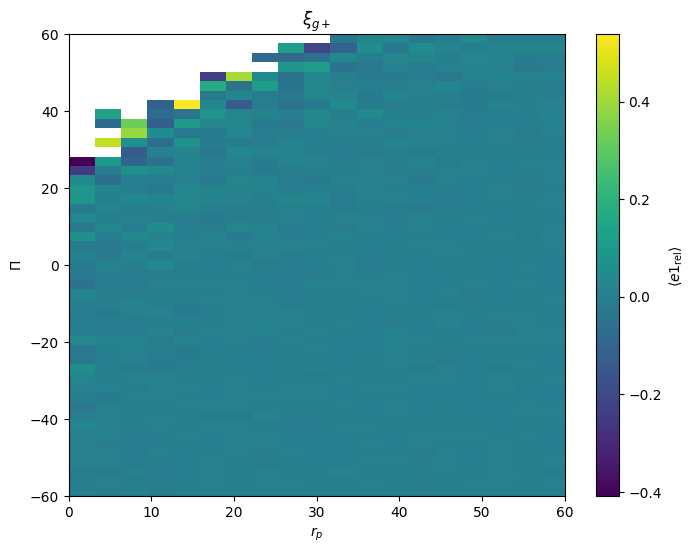

In [321]:
r_p = galaxy_pairs['r_p']
r_par = galaxy_pairs['r_par']
e1_rel = galaxy_pairs['e1_rel']



# Définir les bins pour r_p et r_par
rp_bins = np.linspace(0, 60, 20)  # 20 bins pour r_p
rpar_bins = np.linspace(0, 60, 50)  # 20 bins pour r_par

# Calculer la moyenne de e1_rel dans chaque bin
stat, x_edge, y_edge, binnumber = binned_statistic_2d(
    r_p, r_par, e1_rel, statistic='mean', bins=[rp_bins, rpar_bins]
)



# Tracer la heatmap
plt.figure(figsize=(8, 6))
plt.imshow(stat.T, origin='lower', extent=[0, 60, -60, 60], 
           aspect='auto', cmap='viridis')
plt.colorbar(label=r'$\langle e1_{\text{rel}} \rangle$')
plt.xlabel(r'$r_p$')
plt.ylabel(r'$\Pi$')
plt.title(r'$\xi_{g+}$')
plt.show()

In [ ]:
rp_values = pairs[:, 2] ; pi_values = pairs[:, 3] ; angle_values = pairs[:, 4]


e1_values = e1[i_indices] ; e2_values = e2[i_indices]

e_tangential = -(e1_values * np.cos(2 * angle_values) + e2_values * np.sin(2 * angle_values))


rp_bins = np.linspace(0,60, 20)
pi_bins = np.linspace(0,60, 50)


valid = ~np.isnan(e_tangential)
rp_values = rp_values[valid]
pi_values = pi_values[valid]
e_tangential = e_tangential[valid]


stat, x_edge, y_edge, binnumber = binned_statistic_2d(
    rp_values, pi_values, e_tangential, statistic='mean', bins=[rp_bins, pi_bins]
)

stat = gaussian_filter(stat, sigma=1)
#stat_flipped = np.flip(stat, axis=0)


plt.figure(figsize=(8, 6))
plt.imshow(stat.T, origin='lower', extent=[0, 60, -60, 60])
plt.colorbar(label=r'$\xi_{g+}$')
plt.xlabel(r'$r_p$ [Mpc]')
plt.ylabel(r'$\Pi$ [Mpc]')
plt.title(r'$\xi_{g+}(r_p,\Pi)$')
plt.show()

In [88]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


chi = cosmo.comoving_distance(unions_lrg2['Z'] ).value


x = chi * np.cos(unions_lrg['RA'].values * np.pi/180) * np.cos(unions_lrg['Dec'].values * np.pi/180)
y = chi * np.sin(unions_lrg['RA'].values * np.pi/180) * np.cos(unions_lrg['Dec'].values * np.pi/180) 
z = chi * np.sin(unions_lrg['Dec'].values * np.pi/180)


positions = np.vstack([x, y, z]).T


e1 = unions_lrg['e1'].values ; e2 = unions_lrg['e2'].values

In [71]:
sum(valid)/len(valid)

0.6111593796050603

In [397]:
any(np.isnan(angle_values)) 

True

In [396]:
any(np.isnan(e2_values))

False

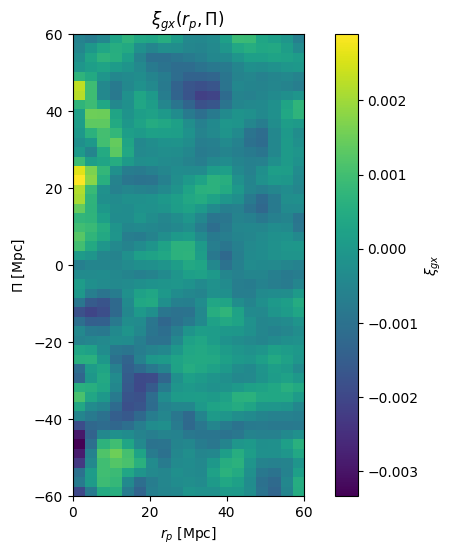

In [13]:
rp_values = pairs[:, 2] ; pi_values = pairs[:, 3] ; angle_values = pairs[:, 4] ; e1_values = e1[i_indices] ; e2_values = e2[i_indices]


e_cross = e1_values * np.sin(2 * angle_values) - e2_values * np.cos(2 * angle_values)


# rp_bins = np.linspace(0,60, 20)
# pi_bins = np.linspace(0,60, 50)


valid = ~np.isnan(e_cross)
rp_values = rp_values[valid]
pi_values = pi_values[valid]
e_cross = e_cross[valid]


stat2, x_edge, y_edge, binnumber = binned_statistic_2d(
    rp_values, pi_values, e_cross, statistic='mean', bins=[rp_bins, pi_bins]
)

stat2 = gaussian_filter(stat2, sigma=1)


plt.figure(figsize=(8, 6))
plt.imshow(stat2.T, origin='lower', extent=[0, 60, -60, 60])
plt.colorbar(label=r'$\xi_{gx}$')
plt.xlabel(r'$r_p$ [Mpc]')
plt.ylabel(r'$\Pi$ [Mpc]')
plt.title(r'$\xi_{gx}(r_p,\Pi)$')
plt.show()

In [269]:
e_tangential

array([-0.03649334, -0.06583939, -0.07558353, ..., -0.10005776,
       -0.1148839 , -0.11964832])

In [ ]:
# Sélectionner les données pour le premier bin de pi
pi_index = 3  # Premier bin de pi
pe_first_pi_bin = pe[:, pi_index, :]  # Extraire les P(e) pour tous les bins de rp dans le premier bin de pi

# Tracer les P(e) pour chaque bin de rp
plt.figure(figsize=(10, 6))
for i in range(n_rp_bins):
    plt.plot(e_bins[:-1], pe_first_pi_bin[i, :], label=f"rp: {rp_bins[i]:.1f}-{rp_bins[i+1]:.1f}")

# Ajouter des labels et une légende
plt.xlabel(r"$\vert e \vert$")
plt.ylabel("P(e)")
plt.title(f"P(e) par bin de rp pour pi: {pi_bins[0]:.1f}-{pi_bins[1]:.1f}")
plt.ylim(0, 0.2)  # Fixer les limites de l'axe y
plt.legend(loc="upper right", fontsize="small")
plt.grid(False)  # Pas de grille
plt.tight_layout()
plt.show()

In [62]:
rp_bins = np.linspace(0, 60, 5) ; n_rp_bins = len(rp_bins) - 1

pi_bins = np.linspace(0, 60, 5) ; n_pi_bins = len(pi_bins) - 1

e_bins = np.linspace(0, 1, 51)


e = np.zeros((n_rp_bins, n_pi_bins, 50)) ; pe = np.zeros((n_rp_bins, n_pi_bins, 50))



rp_values = pairs[:, 2] ; pi_values = pairs[:, 3] ; angle_values = pairs[:, 4]

galaxy1_indices = pairs[:, 0].astype(int) ; galaxy2_indices = pairs[:, 1].astype(int)



e1_values = unions_lrg['e1'].values[galaxy1_indices] ; e2_values = unions_lrg['e2'].values[galaxy1_indices]

e_vals = np.vectorize(abs_e)(e1_values, e2_values)



rp_bin_indices = np.digitize(rp_values, rp_bins) - 1 ; pi_bin_indices = np.digitize(pi_values, pi_bins) - 1


valid_indices = (rp_bin_indices >= 0) & (rp_bin_indices < n_rp_bins) & \
                (pi_bin_indices >= 0) & (pi_bin_indices < n_pi_bins)

rp_bin_indices = rp_bin_indices[valid_indices] ; pi_bin_indices = pi_bin_indices[valid_indices] ; e_vals = e_vals[valid_indices]




for i in range(n_rp_bins):
    for p in range(n_pi_bins):
        in_bin = (rp_bin_indices == i) & (pi_bin_indices == p)
        if np.any(in_bin):
            e[i, p, :], _ = np.histogram(e_vals[in_bin], bins=e_bins)
            pe[i, p, :] = e[i, p, :] / np.sum(e[i, p, :])

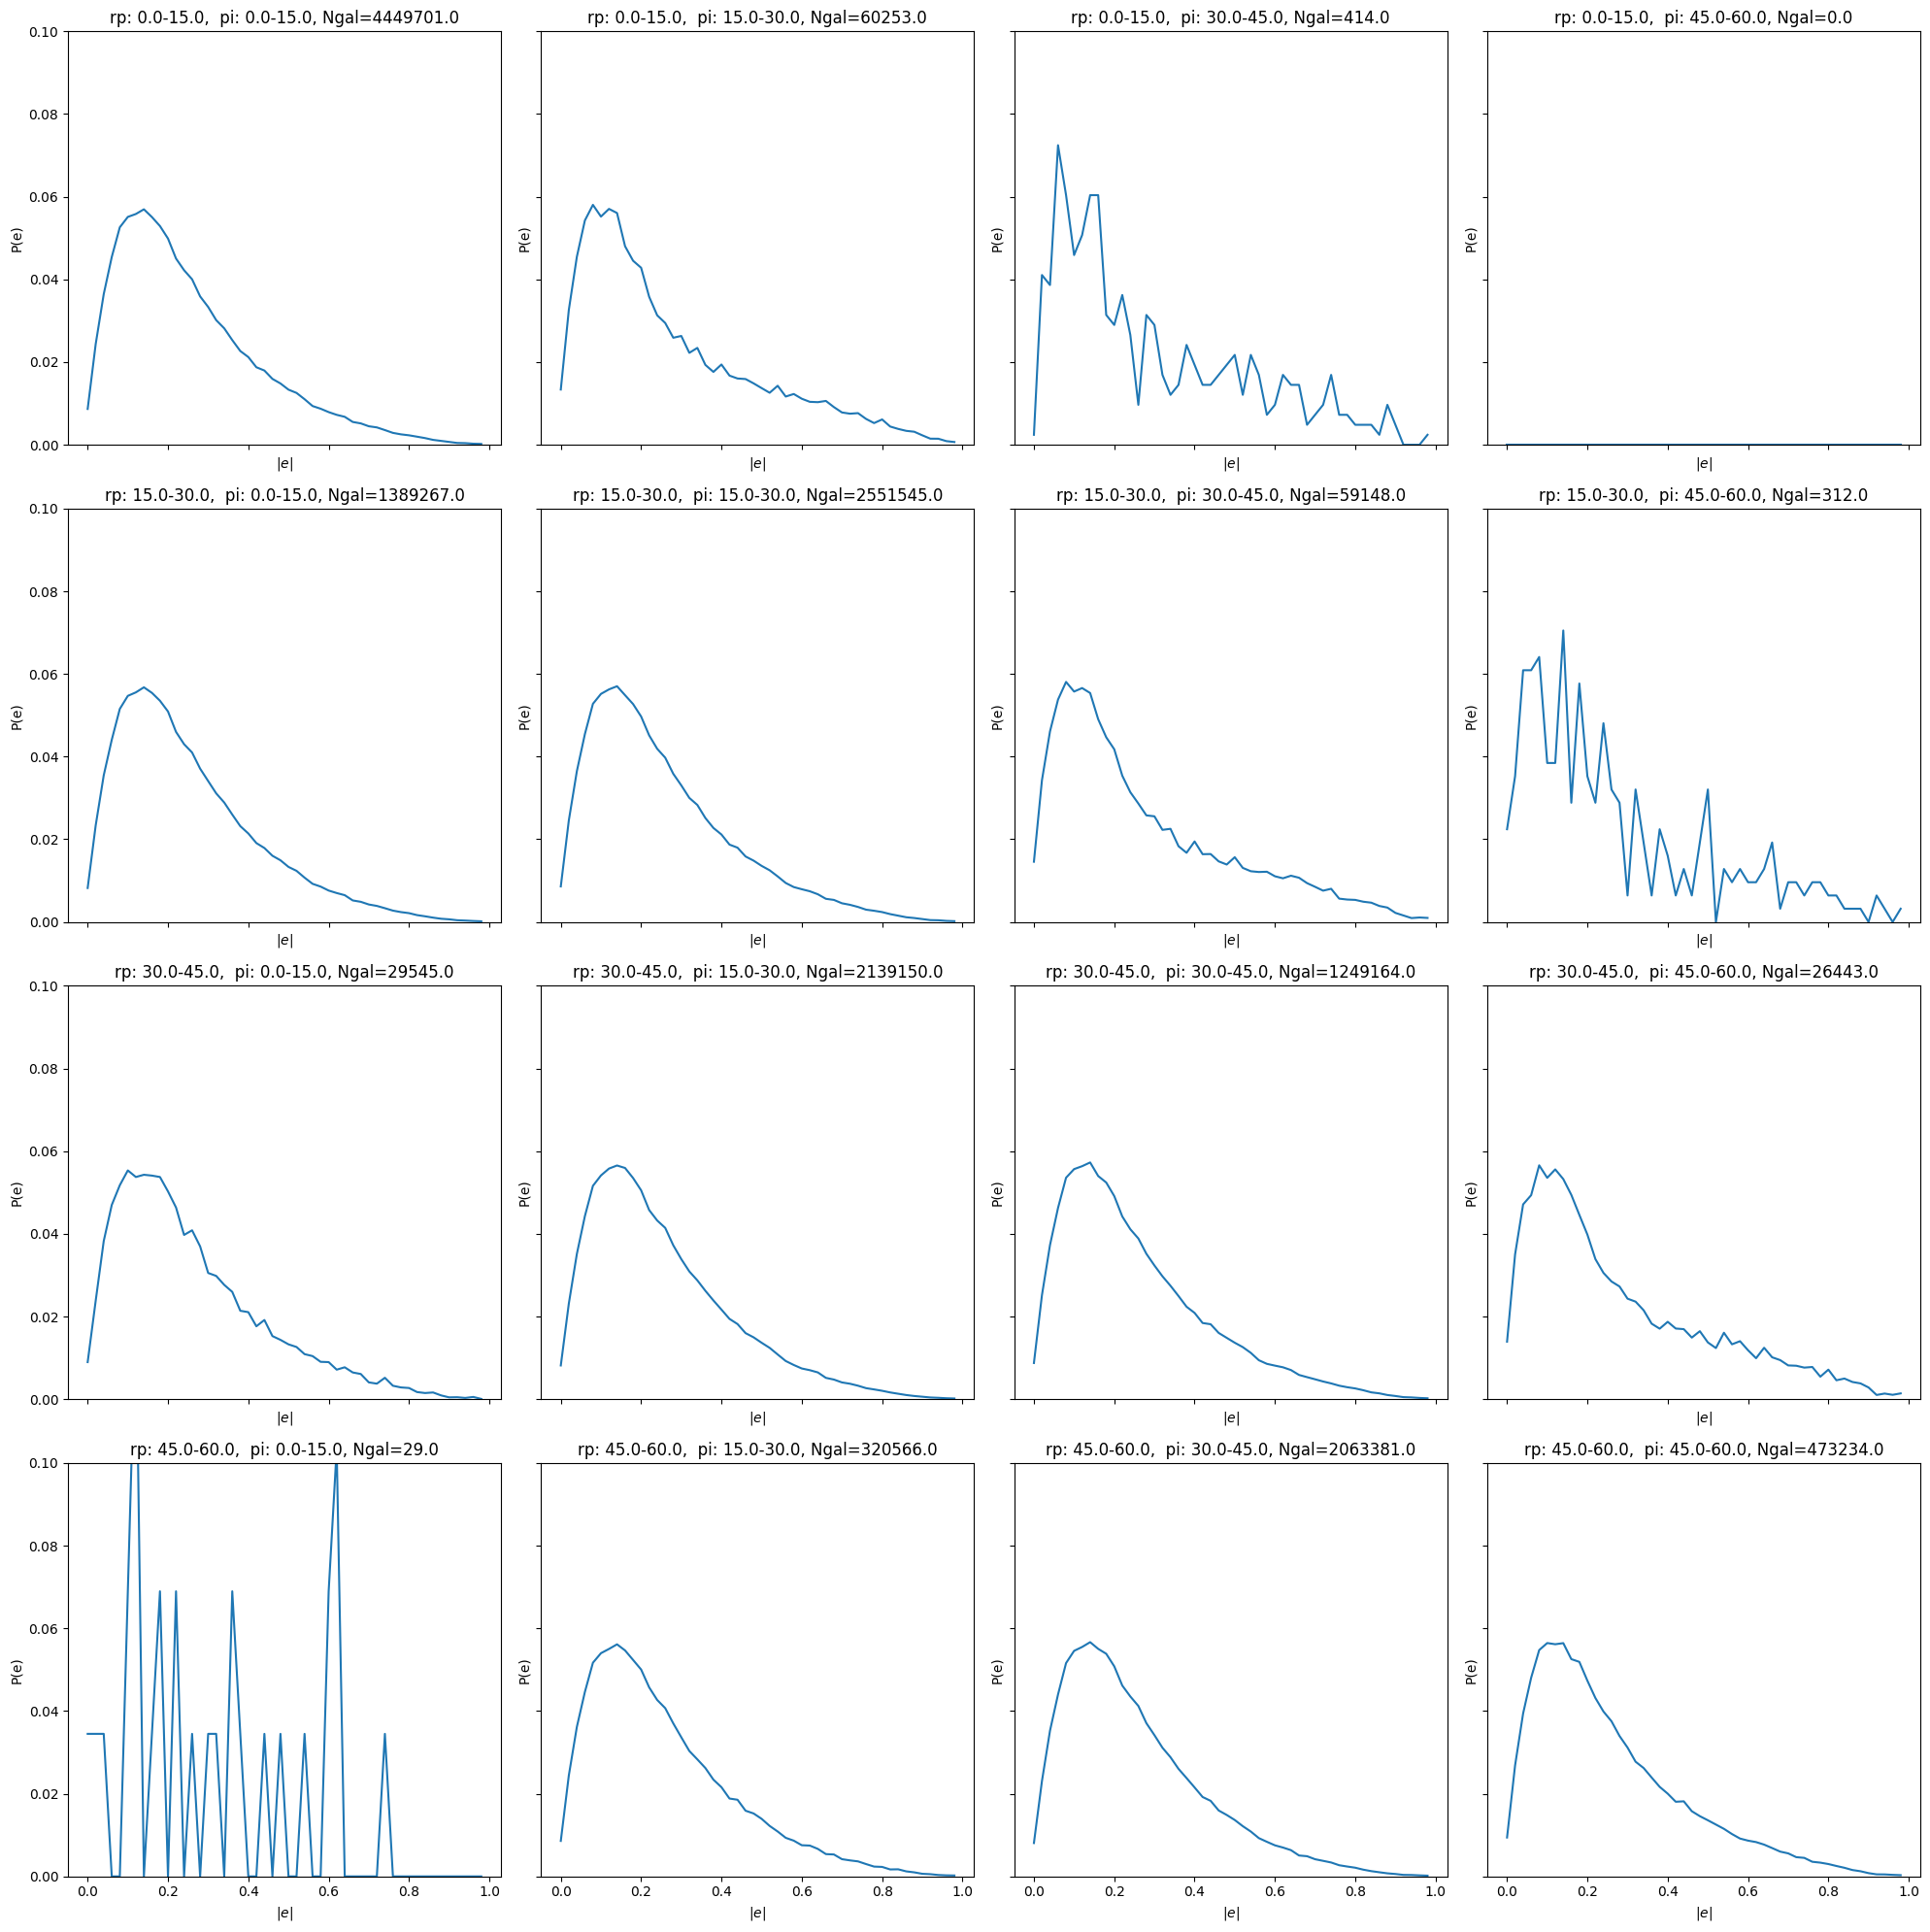

In [27]:
# Définir le nombre de sous-graphiques
fig, axes = plt.subplots(n_rp_bins, n_pi_bins, figsize=(20, 20), sharex=True, sharey=True)

# Parcourir chaque bin de rp et pi
for i in range(n_rp_bins):
    for p in range(n_pi_bins):
        ax = axes[i, p]
        
        # Tracer P(e) pour le bin (i, p)
        ax.plot(e_bins[:-1], pe[i, p, :], label=f"rp_bin={i}, pi_bin={p}")
        
        # Ajouter des titres et des labels
        ax.set_title(f"rp: {rp_bins[i]:.1f}-{rp_bins[i+1]:.1f},  pi: {pi_bins[p]:.1f}-{pi_bins[p+1]:.1f}, Ngal={np.sum(e[i, p, :])}")
        ax.set_xlabel(r"$\vert e \vert$")
        ax.set_ylabel("P(e)")
        ax.grid(False)
        ax.set_ylim(0, 0.1)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()


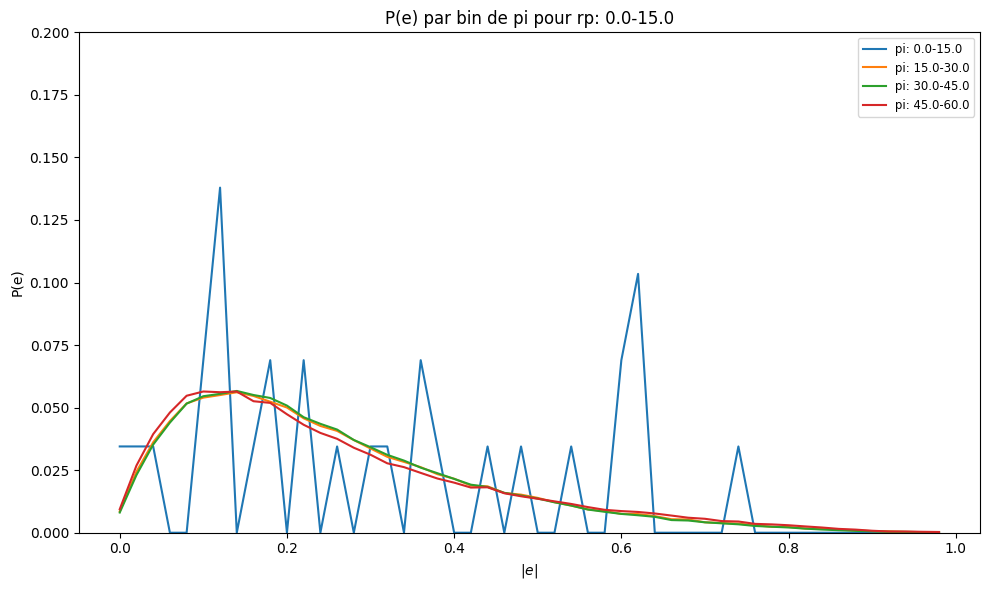

In [147]:
# Sélectionner les données pour le premier bin de rp
rp_index = 3  # Premier bin de rp
pe_first_rp_bin = pe[rp_index, :, :]  # Extraire les P(e) pour tous les bins de pi dans le premier bin de rp

# Tracer les P(e) pour chaque bin de pi
plt.figure(figsize=(10, 6))
for p in range(n_pi_bins):
    plt.plot(e_bins[:-1], pe_first_rp_bin[p, :], label=f"pi: {pi_bins[p]:.1f}-{pi_bins[p+1]:.1f}")

# Ajouter des labels et une légende
plt.xlabel(r"$\vert e \vert$")
plt.ylabel("P(e)")
plt.title(f"P(e) par bin de pi pour rp: {rp_bins[0]:.1f}-{rp_bins[1]:.1f}")
plt.ylim(0, 0.2)  # Fixer les limites de l'axe y
plt.legend(loc="upper right", fontsize="small")
plt.grid(False)  # Pas de grille
plt.tight_layout()
plt.show()

In [343]:
rp_bins = np.linspace(0, 60, 20) ; pi_bins = np.linspace(0, 60, 50)
n_rp_bins = len(rp_bins) - 1 ; n_pi_bins = len(pi_bins) - 1


xi_g_plus = np.zeros((n_rp_bins, n_pi_bins)) ; xi_g_cross = np.zeros((n_rp_bins, n_pi_bins))


rp_values = pairs[:, 2] ; pi_values = pairs[:, 3] ; angle_values = pairs[:, 4]


galaxy1_indices = pairs[:, 0].astype(int) ; galaxy2_indices = pairs[:, 1].astype(int)


e1_values = unions_cmass['e1'].values[galaxy1_indices] ; e2_values = unions_cmass['e2'].values[galaxy1_indices]


e_tangential = -(e1_values * np.cos(2 * angle_values) + e2_values * np.sin(2 * angle_values))

e_cross = -(e1_values * np.sin(2 * angle_values) - e2_values * np.cos(2 * angle_values))


rp_bin_indices = np.digitize(rp_values, rp_bins) - 1 ; pi_bin_indices = np.digitize(pi_values, pi_bins) - 1


valid_indices = (rp_bin_indices >= 0) & (rp_bin_indices < n_rp_bins) & \
                (pi_bin_indices >= 0) & (pi_bin_indices < n_pi_bins)


rp_bin_indices = rp_bin_indices[valid_indices] ; pi_bin_indices = pi_bin_indices[valid_indices]
e_tangential = e_tangential[valid_indices] ; e_cross = e_cross[valid_indices]


for i in range(n_rp_bins):
    for p in range(n_pi_bins):
        in_bin = (rp_bin_indices == i) & (pi_bin_indices == p)
        if np.any(in_bin):
            xi_g_plus[i, p] = np.mean(e_tangential[in_bin])
            xi_g_cross[i, p] = np.mean(e_cross[in_bin])



xi_gp_lrg = gaussian_filter(xi_g_plus, sigma=1)
xi_gc_lrg = gaussian_filter(xi_g_cross, sigma=1)

Text(0.5, 1.0, 'LRG-UNIONS $\\xi_{gx}$')

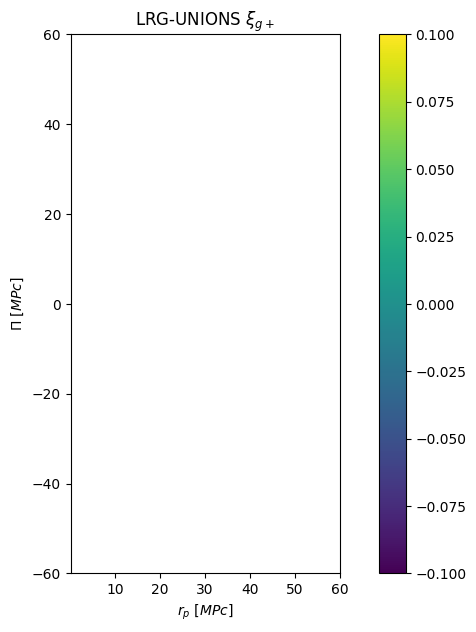

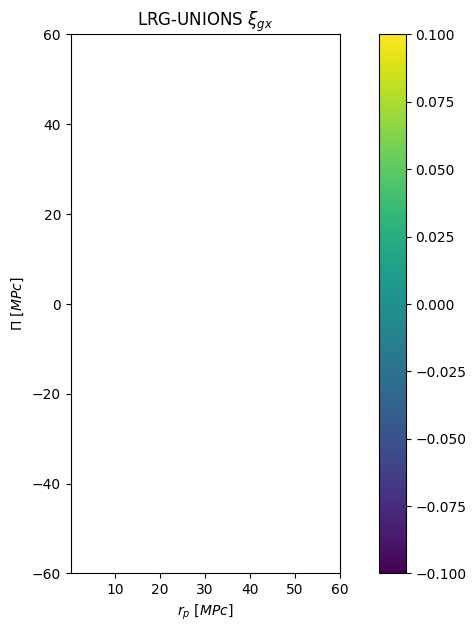

In [344]:
plt.figure(figsize=(10, 7))
plt.imshow(xi_gp_lrg, extent=[0.1,60,-60,60])
plt.colorbar()
plt.xlabel(r"$r_p~[MPc]$"); plt.ylabel(r"$\Pi~[MPc]$")
plt.title(r"LRG-UNIONS $\xi_{g+}$")



plt.figure(figsize=(10, 7))
plt.imshow(xi_gc_lrg, extent=[0.1,60,-60,60])
plt.colorbar()
plt.xlabel(r"$r_p~[MPc]$"); plt.ylabel(r"$\Pi~[MPc]$")
plt.title(r"LRG-UNIONS $\xi_{gx}$")

In [100]:
# Créer un tableau pour accumuler les valeurs de e_tangential et compter les paires dans chaque bin
sum_e_tangential = np.zeros((n_rp_bins, n_pi_bins))
pair_counts = np.zeros((n_rp_bins, n_pi_bins))

# Boucle sur toutes les paires pour les binning
for i in range(len(rp_values)):
    rp = rp_values[i]
    pi = pi_values[i]
    et = e_tangential[i]

    # Trouver les indices des bins correspondants
    rp_bin = np.digitize(rp, rp_bins) - 1
    pi_bin = np.digitize(pi, pi_bins) - 1

    # Vérifier si l'indice est dans les limites
    if 0 <= rp_bin < n_rp_bins and 0 <= pi_bin < n_pi_bins:
        sum_e_tangential[rp_bin, pi_bin] += et
        pair_counts[rp_bin, pi_bin] += 1

# Calcul de la moyenne de e_tangential
with np.errstate(divide='ignore', invalid='ignore'):
    mean_e_tangential = np.divide(sum_e_tangential, pair_counts)
    mean_e_tangential[np.isnan(mean_e_tangential)] = 0.0  # Remplacer les NaN par 0

# Plotting avec imshow
plt.figure(figsize=(8, 6))
extent = [pi_bins[0], pi_bins[-1], rp_bins[0], rp_bins[-1]]
plt.imshow(mean_e_tangential, extent=extent, origin='lower', aspect='auto', cmap='coolwarm')
plt.colorbar(label='Mean $e_{tangential}$')
plt.xlabel(r'$\pi$ (Mpc/h)')
plt.ylabel(r'$r_p$ (Mpc/h)')
plt.title('Mean $e_{tangential}$ in $r_p$ - $\pi$ bins')
plt.tight_layout()
plt.show()

<>:32: SyntaxWarning: invalid escape sequence '\p'
<>:32: SyntaxWarning: invalid escape sequence '\p'
/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_99835/673600530.py:32: SyntaxWarning: invalid escape sequence '\p'
  plt.title('Mean $e_{tangential}$ in $r_p$ - $\pi$ bins')
/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_99835/673600530.py:32: SyntaxWarning: invalid escape sequence '\p'
  plt.title('Mean $e_{tangential}$ in $r_p$ - $\pi$ bins')


KeyboardInterrupt: 

In [ ]:
def get_proj_dist_abacus(cat1, cat2, pos_obs=np.asarray([-3700, 0, 0])*.7):
    '''
    Returns transverse projected distance of two cartesian positions given observer position. 
    Input:
        cat1: astropy table with keys 'x_L2com', 'y_L2com', 'z_L2com'
        cat2: astropy table with keys 'x_L2com', 'y_L2com', 'z_L2com'
        pos_obs: cartesian position of observer. default is [-3700, 0, 0] Mpc/h
    returns in same units as given. default is Mpc/h
    '''
    pos_diff = cat2['x_L2com'] - cat1['x_L2com']
    pos_mid = .5 * (cat2['x_L2com'] + cat1['x_L2com'])
    obs_vec = pos_mid - pos_obs
    
    # project separation vector between objects onto LOS vector
    proj = np.sum(pos_diff*obs_vec, axis=1) / np.linalg.norm(obs_vec, axis=1)
    proj_v = (proj[:, np.newaxis] * obs_vec) / np.linalg.norm(obs_vec, axis=1)[:, np.newaxis]

    # subtract this vector from the separation vector
    # magnitude is projected transverse distance
    transverse_v = pos_diff - proj_v
    
    return np.linalg.norm(transverse_v, axis=1)

In [160]:
def get_proj_dist_abacus(cat1, cat2, pos_obs=np.asarray([-3700, 0, 0])*.7):
    '''
    Returns transverse projected distance of two cartesian positions given observer position. 
    Input:
        cat1: astropy table with keys 'x_L2com', 'y_L2com', 'z_L2com'
        cat2: astropy table with keys 'x_L2com', 'y_L2com', 'z_L2com'
        pos_obs: cartesian position of observer. default is [-3700, 0, 0] Mpc/h
    returns in same units as given. default is Mpc/h
    '''
    pos_diff = cat2['x_L2com'] - cat1['x_L2com']
    pos_mid = .5 * (cat2['x_L2com'] + cat1['x_L2com'])
    obs_vec = pos_mid - pos_obs
    
    # project separation vector between objects onto LOS vector
    proj = np.sum(pos_diff*obs_vec, axis=1) / np.linalg.norm(obs_vec, axis=1)
    proj_v = (proj[:, np.newaxis] * obs_vec) / np.linalg.norm(obs_vec, axis=1)[:, np.newaxis]

    # subtract this vector from the separation vector
    # magnitude is projected transverse distance
    transverse_v = pos_diff - proj_v
    return np.linalg.norm(transverse_v, axis=1)

In [159]:
def get_pair_distances(catalog, indices, pos_obs=np.asarray([-3700, 0, 0])*.7, cartesian=False, use_RSD=True):
    '''
    Calculate distances between input pairs, coordinates in Mpc/h
    -------------------------------------------------------------
    Input:
        catalog: astropy table with keys 'x_L2com', 'y_L2com', 'z_L2com'
        indices: array of indices for n centers and maximum m neighbors each- shape(n,m)
        corresponding to place in catalog
    Returns (for cartesian=False):        
        r_projected: projected distance between centers and neighbors
        r_parallel: LOS distance between centers and neighbors
        s_parallel: LOS distance between centers and neighbors, with RSD
    Returns (for cartesian=True):
        deltax: x distance between centers and neighbors    
        deltayz: yz distance between centers and neighbors
    '''
    # indices in catalog of centers and neighbors, arranges so each array is same shape
    ci = np.repeat(indices[:,0], (len(indices[0])-1)).ravel() # indices of centers
    ni = indices[:,1:].ravel()   # indices of neighbors
    
    # removing places where no neighbor was found in the tree
    neighbor_exists = (ni!=len(catalog))
    ci = ci[neighbor_exists]; ni = ni[neighbor_exists]
    
    centers_m = catalog[ci]
    neighbors_m = catalog[ni]   # excluding the centers
    
    if cartesian==False:
        r_projected = get_proj_dist_abacus(centers_m, neighbors_m, pos_obs)

        if use_RSD == False:
            r_parallel = (np.abs(cosmo.comoving_distance(centers_m['Z']) - cosmo.comoving_distance(neighbors_m['Z'])) * 0.7 / u.Mpc).value
            return r_projected, r_parallel
        else:
            r_parallel = (np.abs(cosmo.comoving_distance(centers_m['Z_noRSD']) - cosmo.comoving_distance(neighbors_m['Z_noRSD'])) * 0.7 / u.Mpc).value
            s_parallel = (np.abs(cosmo.comoving_distance(centers_m['Z_withRSD']) - cosmo.comoving_distance(neighbors_m['Z_withRSD'])) * 0.7 / u.Mpc).value
            return r_projected, r_parallel, s_parallel
    
    elif cartesian==True:
        deltax = np.abs(centers_m['x_L2com'][::,0] - neighbors_m['x_L2com'][::,0])
        deltayz = np.sqrt((centers_m['x_L2com'][::,1] - neighbors_m['x_L2com'][::,1])**2 + (centers_m['x_L2com'][::,2] - neighbors_m['x_L2com'][::,2])**2)
        return deltax, deltayz

In [ ]:
get_pair_distances(haloes_table1, indices, pos_obs=np.asarray([-3700, 0, 0])*.7, cartesian=False, use_RSD=True)

In [125]:
rp_bins = np.linspace(0.1, max_sep, 25)
rp_centers = (rp_bins[:-1] + rp_bins[1:]) / 2

# e histogram binning
e_bins = np.linspace(0, 1, 50)
e_cents = (e_bins[1:] + e_bins[:-1]) / 2

plt.figure(figsize = (10,7))

pi_bins = np.linspace(0,100,25)
pi_min=0 ; pi_max=2

for i in range(len(rp_bins)-1):

    rp_min = rp_bins[i] ; rp_max = rp_bins[i+1]

    # Sélection des paires dans ce bin de rp
    in_bin = (pairs[:,2] >= rp_min) & (pairs[:,2] < rp_max) & (pairs[:,3] >= pi_min) & (pairs[:,3] < pi_max)
    pair_indices = pairs[in_bin][:, :2].astype(int)

    if len(pair_indices) == 0:
        continue  # skip if no pairs

    # Extraire les indices uniques des galaxies concernées
    galaxy_indices = np.unique(pair_indices.flatten())

    # Calcul de l'ellipticité
    e1_values = unions_lrg['e1'].values[galaxy_indices]
    e2_values = unions_lrg['e2'].values[galaxy_indices]

    a_vals, b_vals = np.vectorize(a_b)(e1_values, e2_values)
    theta_vals = np.vectorize(get_galaxy_orientation_angle)(e1_values, e2_values)
    e1_vals, e2_vals = np.vectorize(e_complex)(a_vals, b_vals, theta_vals)
    e_vals = np.vectorize(abs_e)(e1_vals, e2_vals)

    # Histogramme de e
    e_counts, _ = np.histogram(e_vals, bins=e_bins)
    p_e = e_counts / np.sum(e_counts)  # normalisation

    plots_data.append((rp_min, rp_max, p_e))

    plt.plot(e_cents, p_e, label=f'{rp_min:.0f}-{rp_max:.0f} Mpc')


plt.xlabel(r"$\vert e \vert$")
plt.ylabel("Normalized count")
plt.legend(title='Bin of $r_p$')

TypeError: list indices must be integers or slices, not tuple

<Figure size 1000x700 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

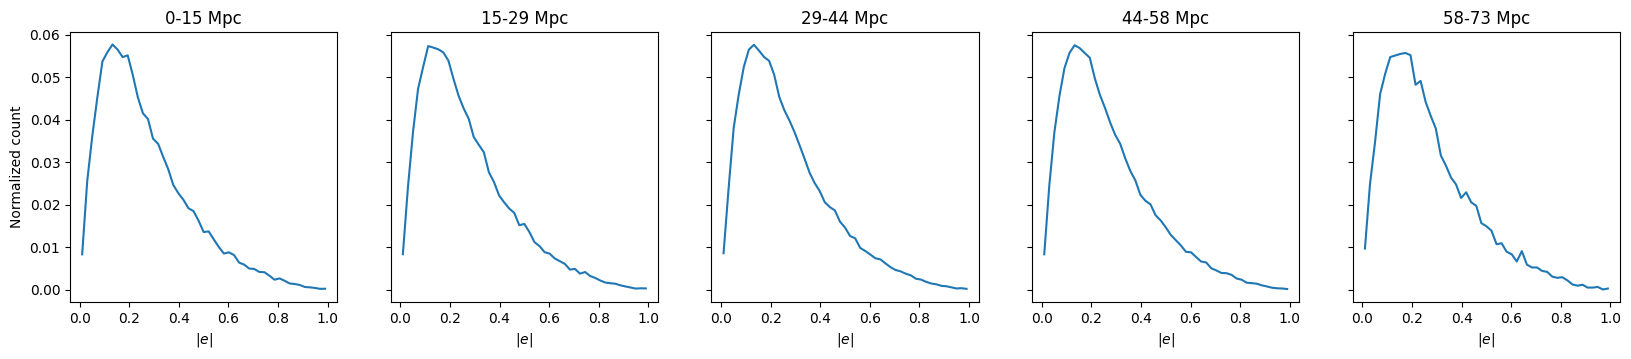

In [13]:
rp_bins = np.linspace(0.1, 350, 25)  # 24 bins
rp_centers = (rp_bins[:-1] + rp_bins[1:]) / 2

# e histogram binning
e_bins = np.linspace(0, 1, 50)
e_cents = (e_bins[1:] + e_bins[:-1]) / 2

pi_min = 0
pi_max = 1

plt.figure(figsize=(20, 10))
# On stocke les données à afficher
plots_data = []

for i in range(len(rp_bins) - 1):
    rp_min = rp_bins[i]
    rp_max = rp_bins[i+1]

    in_bin = (pairs[:, 2] >= rp_min) & (pairs[:, 2] < rp_max) & (pairs[:, 3] >= pi_min) & (pairs[:, 3] < pi_max)
    pair_indices = pairs[in_bin][:, :2].astype(int)

    if len(pair_indices) == 0:
        continue  # on saute les bins sans données

    galaxy_indices = np.unique(pair_indices.flatten())
    e1_values = unions_lrg['e1'].values[galaxy_indices]
    e2_values = unions_lrg['e2'].values[galaxy_indices]

    a_vals, b_vals = np.vectorize(a_b)(e1_values, e2_values)
    theta_vals = np.vectorize(get_galaxy_orientation_angle)(e1_values, e2_values)
    e1_vals, e2_vals = np.vectorize(e_complex)(a_vals, b_vals, theta_vals)
    e_vals = np.vectorize(abs_e)(e1_vals, e2_vals)

    e_counts, _ = np.histogram(e_vals, bins=e_bins)
    p_e = e_counts / np.sum(e_counts)

    plots_data.append((rp_min, rp_max, p_e))

# Déterminer la grille de subplots
n_plots = len(plots_data)
n_cols = 5
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3.5*n_rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, (rp_min, rp_max, p_e) in enumerate(plots_data):
    ax = axes[i]
    ax.plot(e_cents, p_e)
    ax.set_title(f'{rp_min:.0f}-{rp_max:.0f} Mpc')
    if i % n_cols == 0:
        ax.set_ylabel("Normalized count")
    if i >= (n_rows - 1) * n_cols:
        ax.set_xlabel(r"$\vert e \vert$")

# Supprimer les subplots restants non utilisés
for j in range(n_plots, len(axes)):
    axes[j].remove()

plt.show()

In [50]:
rp_bins = np.linspace(0, 60, 20) ; n_rp_bins = len(rp_bins)-1

pi_bins = np.linspace(0, 60, 50) ; n_pi_bins = len(pi_bins)-1

xi_g_plus = np.zeros((n_rp_bins, n_pi_bins))
xi_g_cross = np.zeros((n_rp_bins, n_pi_bins))

indices1 = np.zeros((n_rp_bins, n_pi_bins))
indices2 = np.zeros((n_rp_bins, n_pi_bins))



for p in range(n_pi_bins):

    pi_min = pi_bins[p] ; pi_max = pi_bins[p+1]

    for i in range(n_rp_bins):
        
        rp_min = rp_bins[i] ; rp_max = rp_bins[i+1]

        in_bin = (
            (pairs[:,2] >= rp_min) & (pairs[:,2] < rp_max) &
            (pairs[:,3] >= pi_min) & (pairs[:,3] < pi_max)
        )
        
        pair_indices = pairs[in_bin][:, :2].astype(int)


        galaxy1_indices = pair_indices[:, 0] ; galaxy2_indices = pair_indices[:, 1]

        angle_values = pairs[in_bin][:,4]


        e1_values = unions_lrg['e1'].values[galaxy2_indices]
        e2_values = unions_lrg['e2'].values[galaxy2_indices]


        e_tangential = -(e1_values * np.cos(2*angle_values) +
                         e2_values * np.sin(2*angle_values))

        e_cross = -(e1_values * np.sin(2*angle_values) -
                    e2_values * np.cos(2*angle_values))


        xi_g_plus[i, p] = np.mean(e_tangential)
        xi_g_cross[i, p] = np.mean(e_cross)
 
    

xi_gp_lrg = gaussian_filter(xi_g_plus, sigma=1)
xi_gc_lrg = gaussian_filter(xi_g_cross, sigma=1)

In [44]:
rp_bins = np.linspace(0.1, 60, 21) 
rp_centers = (rp_bins[:-1] + rp_bins[1:]) / 2
n_rp_bins = len(rp_bins) - 1

pi_bins = np.linspace(0, 60, 51)
n_pi_bins = len(pi_bins)-1

xi_g_plus = np.zeros((n_rp_bins, n_pi_bins))
xi_g_cross = np.zeros((n_rp_bins, n_pi_bins))
pair_counts = np.zeros((len(rp_bins) - 1, len(pi_bins) - 1))

indices1 = np.zeros((n_rp_bins, n_pi_bins))
indices2 = np.zeros((n_rp_bins, n_pi_bins))


for p in range(n_pi_bins):

    pi_min = pi_bins[p] ; pi_max = pi_bins[p+1]

    for i in range(n_rp_bins):
        
        rp_min = rp_bins[i] ; rp_max = rp_bins[i+1]

        in_bin = (
            (pairs[:, 2] >= rp_min) & (pairs[:, 2] < rp_max) &
            (pairs[:, 3] >= pi_min) & (pairs[:, 3] < pi_max)
        )
        
        pair_indices = pairs[in_bin][:, :2].astype(int)

        if len(pair_indices) == 0:
            continue


        galaxy1_indices = pair_indices[:, 0] ; galaxy2_indices = pair_indices[:, 1]

        angle_values = pairs[in_bin][:,4]


        e1_values = unions_lrg['e1'].values[galaxy2_indices]
        e2_values = unions_lrg['e2'].values[galaxy2_indices]



        e_tangential = -(e1_values * np.cos(2 * angle_values) +
                         e2_values * np.sin(2 * angle_values))
        

        e_cross = -(e1_values * np.sin(2 * angle_values) -
                    e2_values * np.cos(2 * angle_values))


        # Mise à jour des histogrammes
        xi_g_plus[i, p] += np.sum(e_tangential)
        xi_g_cross[i, p] += np.sum(e_cross)
        pair_counts[i, p] += len(e_tangential)

# Normalisation pour obtenir les fonctions de corrélation moyennes
xi_g_plus /= np.maximum(pair_counts, 1)  # Évite la division par zéro
xi_g_cross /= np.maximum(pair_counts, 1)  # Évite la division par zéro
        
        
xi_gp_lrg = gaussian_filter(xi_g_plus, sigma=1)
xi_gc_lrg = gaussian_filter(xi_g_cross, sigma=1)
    

Text(0.5, 1.0, 'LRG-UNIONS $\\xi_{gx}$')

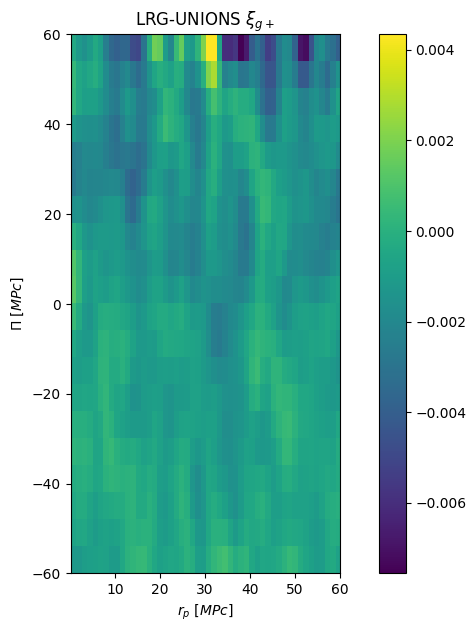

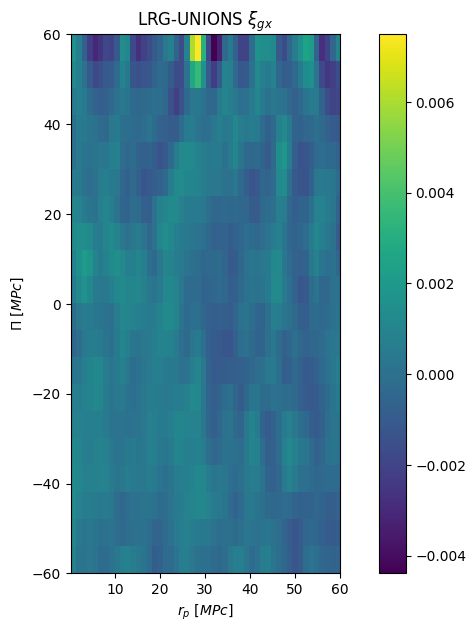

In [45]:
plt.figure(figsize=(10, 7))
plt.imshow(xi_gp_lrg, extent=[0.1,60,-60,60])
plt.colorbar()
plt.xlabel(r"$r_p~[MPc]$"); plt.ylabel(r"$\Pi~[MPc]$")
plt.title(r"LRG-UNIONS $\xi_{g+}$")


plt.figure(figsize=(10, 7))
plt.imshow(xi_gc_lrg, extent=[0.1,60,-60,60])
plt.colorbar()
plt.xlabel(r"$r_p~[MPc]$"); plt.ylabel(r"$\Pi~[MPc]$")
plt.title(r"LRG-UNIONS $\xi_{gx}$")

In [64]:
# Assuming `pairs` contains galaxy pair data and `unions_lrg` contains galaxy properties
rp_bins = np.linspace(0.1, max_sep, 21)  # 20 bins
rp_centers = (rp_bins[:-1] + rp_bins[1:]) / 2
n_rp_bins = len(rp_bins) - 1

pi_bins = np.linspace(0, 60, 51)  # 50 bins
n_pi_bins = len(pi_bins) - 1

# Initialize arrays to store results
chi_g_plus = np.zeros((n_rp_bins, n_pi_bins))
chi_g_cross = np.zeros((n_rp_bins, n_pi_bins))

for p in range(n_pi_bins):
    pi_min = pi_bins[p]
    pi_max = pi_bins[p + 1]

    for i in range(n_rp_bins):
        rp_min = rp_bins[i]
        rp_max = rp_bins[i + 1]

        # Select pairs in the current bin
        in_bin = (
            (pairs[:, 2] >= rp_min) & (pairs[:, 2] < rp_max) &
            (pairs[:, 3] >= pi_min) & (pairs[:, 3] < pi_max)
        )
        pair_indices = pairs[in_bin][:, :2].astype(int)

        if len(pair_indices) == 0:
            continue  # Skip if no data

        # Extraire les indices uniques des galaxies concernées
        galaxy_indices = np.unique(pair_indices.flatten())

        # Calcul de l'ellipticité
        e1_values = unions_lrg['e1'].values[galaxy_indices]
        e2_values = unions_lrg['e2'].values[galaxy_indices]

        a_vals, b_vals = np.vectorize(a_b)(e1_values, e2_values)
        theta_vals = np.vectorize(get_galaxy_orientation_angle)(e1_values, e2_values)
        e1_vals, e2_vals = np.vectorize(e_complex)(a_vals, b_vals, theta_vals)
        e_vals = np.vectorize(abs_e)(e1_vals, e2_vals)

        # Get unique galaxy indices and their ellipticity components
        galaxy_indices = np.unique(pair_indices.flatten())
        e1_values = unions_lrg['e1'].values[galaxy_indices]
        e2_values = unions_lrg['e2'].values[galaxy_indices]

        # Compute separation vectors and angles
        dx = pairs[in_bin][:, 0]  # x-separation
        dy = pairs[in_bin][:, 1]  # y-separation
        separation_angle = np.arctan2(dy, dx)

        # Project ellipticities into tangential and cross components
        e_tangential = -(e1_values * np.cos(2 * separation_angle) +
                         e2_values * np.sin(2 * separation_angle))
        e_cross = -(e1_values * np.sin(2 * separation_angle) -
                    e2_values * np.cos(2 * separation_angle))

        # Compute averages for the bin
        chi_g_plus[i, p] = np.mean(e_tangential)
        chi_g_cross[i, p] = np.mean(e_cross)

        
# xi_gp_lrg = gaussian_filter(chi_g_plus, sigma=1)
# xi_gc_lrg = gaussian_filter(chi_g_cross, sigma=1)

ValueError: operands could not be broadcast together with shapes (242134,) (463326,) 

In [ ]:
xi_g_plus_proj = np.sum(xi_g_plus * np.diff(pi_bins)[None, :], axis=1)
xi_g_cross_proj = np.sum(xi_g_cross * np.diff(pi_bins)[None, :], axis=1)

In [427]:
nrp = 21 ; npi = 51

shape_cat = treecorr.Catalog(x=x,y=y,z=z,g1=e1,g2=e2)

pi = np.linspace(-60,60,npi)


xi_gp = [] ; xi_gp = list(xi_gp) ; xi_gc = [] ; xi_gc = list(xi_gc)
rp = [] ; rp = list(rp) ; var = [] ; var = list(var)


for i in np.arange(0, npi-1):
    ng = treecorr.NGCorrelation(nbins=nrp, 
                                min_sep = 0,
                                max_sep = 60.,
                                min_rpar = pi[i],
                                max_rpar = pi[i+1],
                                bin_type='Linear')
    ng.process(shape_cat, shape_cat, metric ='OldRperp')

    xi_p = ng.raw_xi ; xi_c = ng.raw_xi_im ; var2 = ng.raw_varxi ; r = ng.logr
    xi_gp.append(xi_p) ; xi_gc.append(xi_c) ; var.append(var2) ; rp.append(r) 
    

xi_gp_lrg=np.array(xi_gp) ; xi_gc_lrg=np.array(xi_gc) ; var = np.array(var) ; r_lrg = np.array(rp)


Text(0.5, 1.0, 'LRG-UNIONS $\\xi_{gx}$')

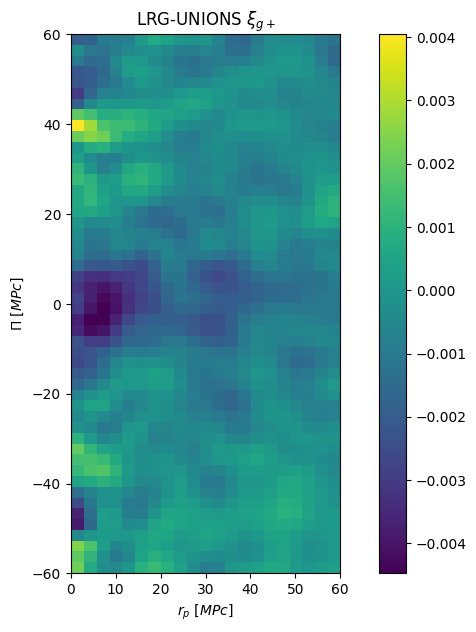

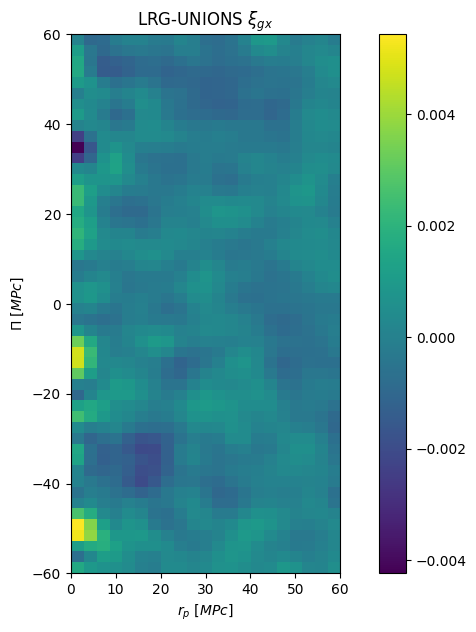

In [428]:
xi_gp_lrg = gaussian_filter(xi_gp_lrg, sigma=1)
xi_gc_lrg = gaussian_filter(xi_gc_lrg, sigma=1)


plt.figure(figsize=(10, 7))
plt.imshow(xi_gp_lrg, extent=[0,60,-60,60])
plt.colorbar()
plt.xlabel(r"$r_p~[MPc]$"); plt.ylabel(r"$\Pi~[MPc]$")
plt.title(r"LRG-UNIONS $\xi_{g+}$")


plt.figure(figsize=(10, 7))
plt.imshow(xi_gc_lrg, extent=[0,60,-60,60])
plt.colorbar()
plt.xlabel(r"$r_p~[MPc]$"); plt.ylabel(r"$\Pi~[MPc]$")
plt.title(r"LRG-UNIONS $\xi_{gx}$")

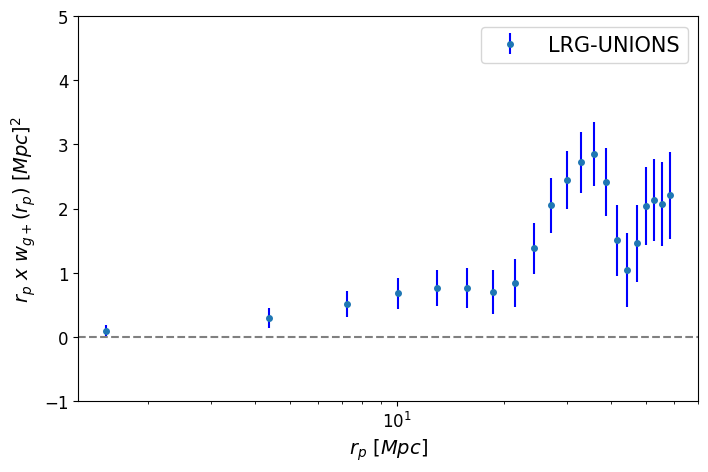

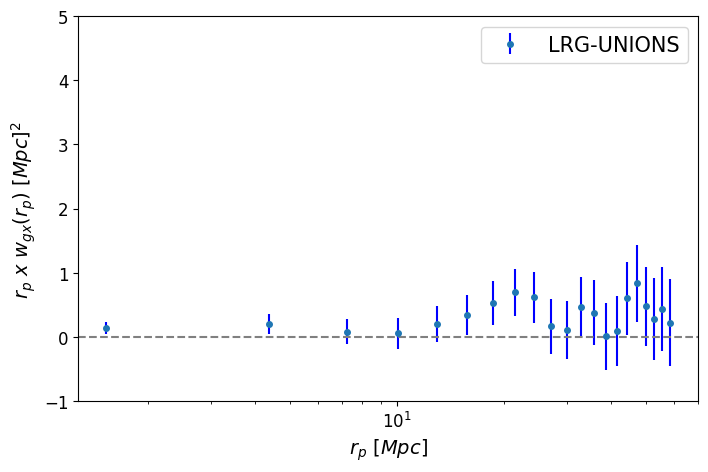

In [48]:
wgp_lrg = np.zeros(nrp) ; wgc_lrg = np.zeros(nrp) ; var2 = np.zeros(nrp)

for i in range (nrp):
    wgp_lrg[i] = abs(np.sum(xi_gp_lrg[:,i]))
    wgc_lrg[i] = abs(np.sum(xi_gc_lrg[:,i]))
    var2[i] = np.sum(var[:,i])

sigma_lrg = np.sqrt(var2)


plt.figure(figsize=(8,5))
plt.errorbar(np.exp(r_lrg[0,:]),np.exp(r_lrg[0,:])/0.7**2*wgp_lrg,
             yerr=np.exp(r_lrg[0,:])/0.7*sigma_lrg,
             label='LRG-UNIONS',ecolor='blue',marker='o', markersize = 4,linestyle='None')


plt.xlabel(r"$r_p~[Mpc]$",fontsize=14)
plt.ylabel(r"$r_p~x~w_{g+}(r_p)~[Mpc]^2$",fontsize=14)
plt.ylim(-1,5)
plt.xscale('log')
plt.axhline(0, ls='--', color='grey')
plt.legend(fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()



plt.figure(figsize=(8,5))
plt.errorbar(np.exp(r_lrg[0,:]),np.exp(r_lrg[0,:])/0.7**2*wgc_lrg,
             yerr=np.exp(r_lrg[0,:])/0.7*sigma_lrg,
             label='LRG-UNIONS',ecolor='blue',marker='o', markersize = 4,linestyle='None')


plt.xlabel(r"$r_p~[Mpc]$",fontsize=14)
plt.ylabel(r"$r_p~x~w_{gx}(r_p)~[Mpc]^2$",fontsize=14)
plt.ylim(-1,5)
plt.xscale('log')
plt.axhline(0, ls='--', color='grey')
plt.legend(fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [213]:
nrp = 21 ; npi = 51

shape_cat = treecorr.Catalog(x=x,y=y,z=z,g1=e1,g2=e2)

pi = np.linspace(-60,60,npi)


xi_gp = [] ; xi_gp = list(xi_gp) ; xi_gc = [] ; xi_gc = list(xi_gc)
rp = [] ; rp = list(rp) ; var = [] ; var = list(var)


for i in np.arange(0, npi-1):
    ng = treecorr.NGCorrelation(nbins=nrp, 
                                min_sep = 0,
                                max_sep = 60.,
                                min_rpar = pi[i],
                                max_rpar = pi[i+1],
                                bin_type='Linear')
    ng.process(shape_cat, shape_cat, metric ='OldRperp')

    xi_p = ng.raw_xi ; xi_c = ng.raw_xi_im ; var2 = ng.raw_varxi ; r = ng.logr
    xi_gp.append(xi_p) ; xi_gc.append(xi_c) ; var.append(var2) ; rp.append(r) 
    

xi_gp_cmass=np.array(xi_gp) ; xi_gc_cmass=np.array(xi_gc) ; var = np.array(var) ; r_cmass = np.array(rp)

Text(0.5, 1.0, '$\\xi_{gx}$ CMASS-UNIONS')

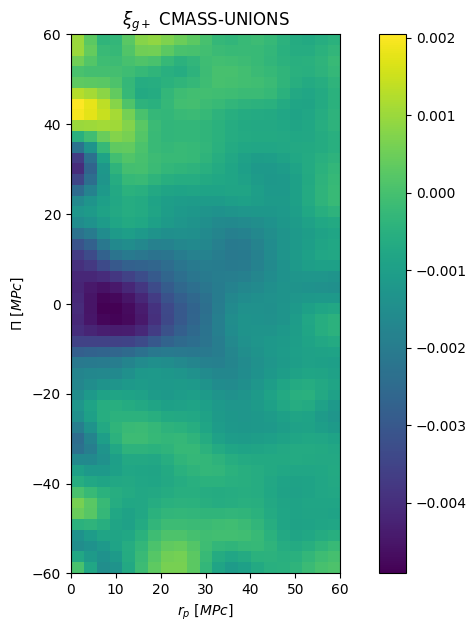

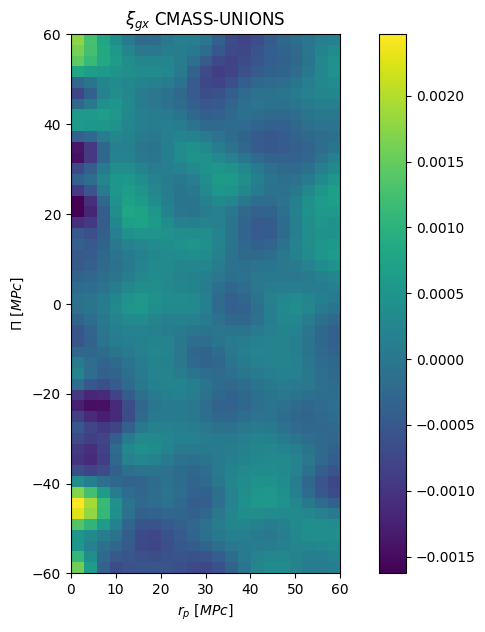

In [215]:
xi_gp_cmass = gaussian_filter(xi_gp_cmass, sigma=1)
xi_gc_cmass = gaussian_filter(xi_gc_cmass, sigma=1)


plt.figure(figsize=(10, 7))
plt.imshow(xi_gp_cmass, extent=[0,60,-60,60])
plt.colorbar()
plt.xlabel(r"$r_p~[MPc]$"); plt.ylabel(r"$\Pi~[MPc]$")
plt.title(r"$\xi_{g+}$ CMASS-UNIONS")


plt.figure(figsize=(10, 7))
plt.imshow(xi_gc_cmass, extent=[0,60,-60,60])
plt.colorbar()
plt.xlabel(r"$r_p~[MPc]$"); plt.ylabel(r"$\Pi~[MPc]$")
plt.title(r"$\xi_{gx}$ CMASS-UNIONS")

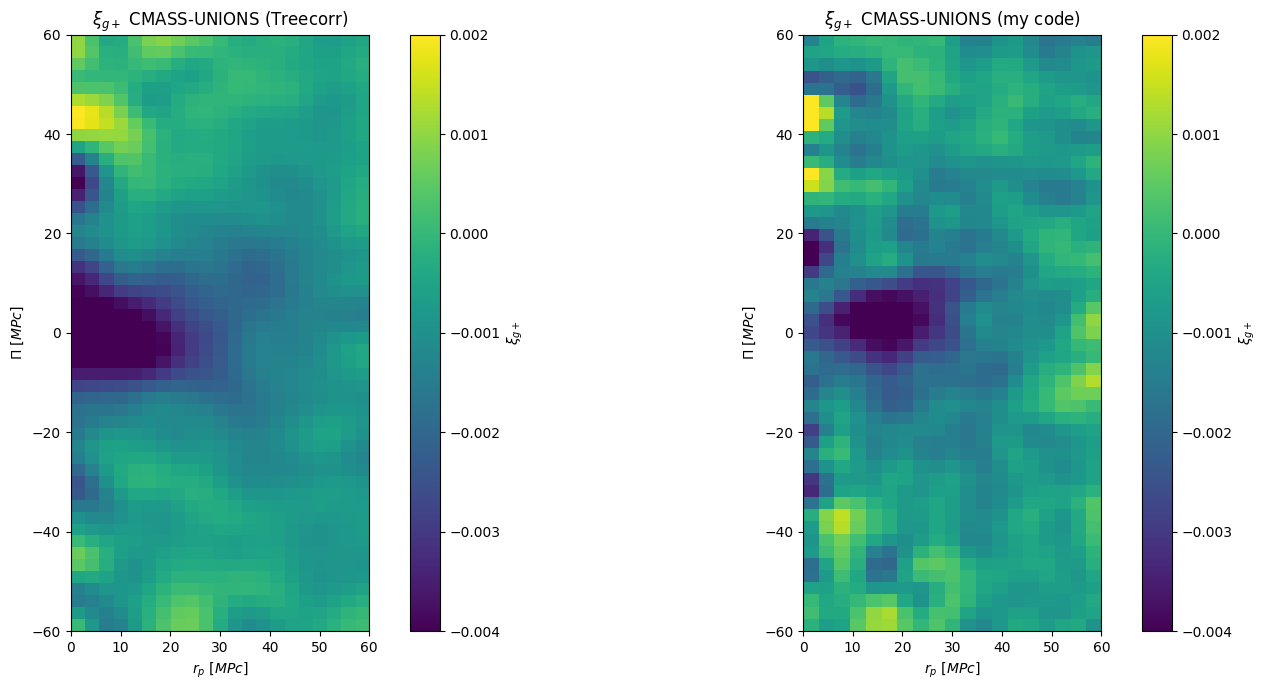

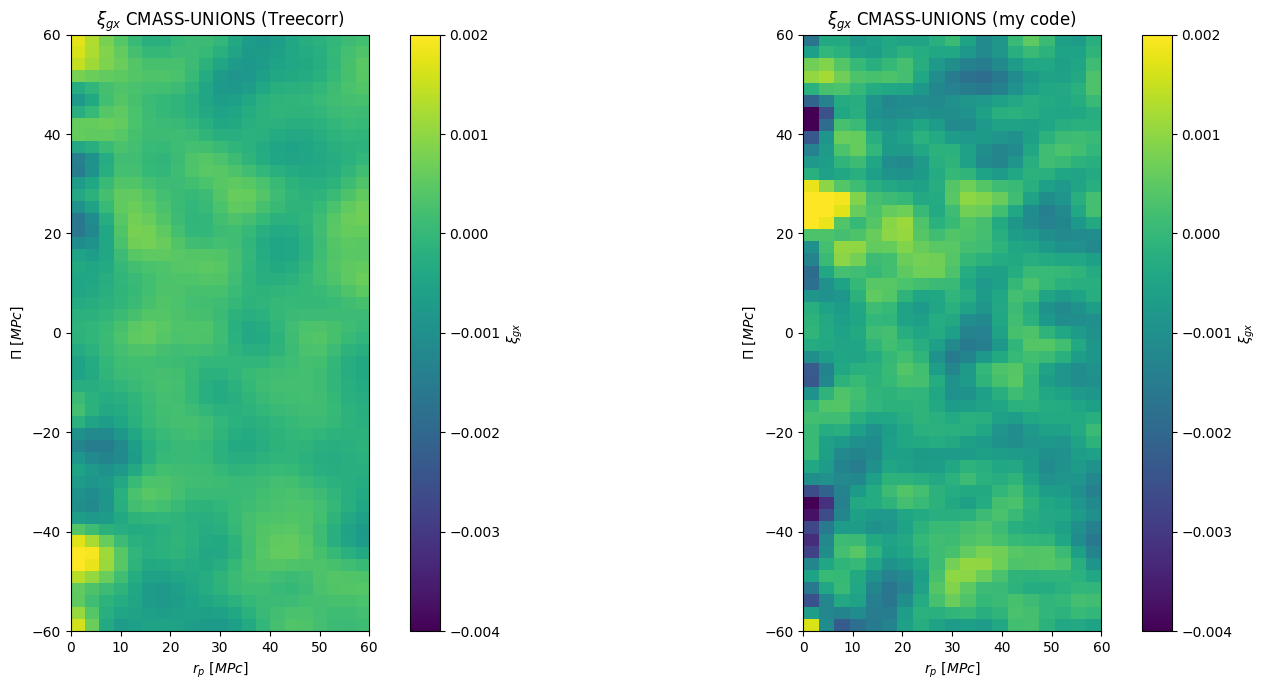

In [232]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

im1 = axes[0].imshow(xi_gp_cmass, extent=[0, 60, -60, 60], vmin=-4*10**-3, vmax=2*10**-3)
axes[0].set_title(r"$\xi_{g+}$ CMASS-UNIONS (Treecorr)")
axes[0].set_xlabel(r"$r_p~[MPc]$")
axes[0].set_ylabel(r"$\Pi~[MPc]$")
cbar1 = fig.colorbar(im1, ax=axes[0], label=r'$\xi_{g+}$')


im2 = axes[1].imshow(stat_cmass.T, origin='lower', extent=[0, 60, -60, 60], vmin=-4*10**-3, vmax=2*10**-3)
axes[1].set_title(r"$\xi_{g+}$ CMASS-UNIONS (my code)")
axes[1].set_xlabel(r"$r_p~[MPc]$")
axes[1].set_ylabel(r"$\Pi~[MPc]$")
cbar2 = fig.colorbar(im2, ax=axes[1], label=r'$\xi_{g+}$')


plt.tight_layout()
plt.show()






fig, axes = plt.subplots(1, 2, figsize=(16, 7))

im1 = axes[0].imshow(xi_gc_cmass, extent=[0, 60, -60, 60], vmin=-4*10**-3, vmax=2*10**-3)
axes[0].set_title(r"$\xi_{gx}$ CMASS-UNIONS (Treecorr)")
axes[0].set_xlabel(r"$r_p~[MPc]$")
axes[0].set_ylabel(r"$\Pi~[MPc]$")
cbar1 = fig.colorbar(im1, ax=axes[0], label=r'$\xi_{gx}$')


im2 = axes[1].imshow(stat2_cmass.T, origin='lower', extent=[0, 60, -60, 60], vmin=-4*10**-3, vmax=2*10**-3)
axes[1].set_title(r"$\xi_{gx}$ CMASS-UNIONS (my code)")
axes[1].set_xlabel(r"$r_p~[MPc]$")
axes[1].set_ylabel(r"$\Pi~[MPc]$")
cbar2 = fig.colorbar(im2, ax=axes[1], label=r'$\xi_{gx}$')


plt.tight_layout()
plt.show()

In [49]:
nrp = 21 ; npi = 51

shape_cat = treecorr.Catalog(x=x,y=y,z=z,g1=e1,g2=e2)

pi = np.linspace(-60,60,npi)

xi_gp = [] ; xi_gc = [] ; rp=[] ; var = [] ; covar = []
xi_gp=list(xi_gp) ; xi_gc = list (xi_gc) ; rp = list(rp) ; var = list(var) ; covar = list(covar)

for i in np.arange(0, npi-1):
    ng = treecorr.NGCorrelation(nbins=nrp,
                                min_sep = 0.1,
                                max_sep = 60.,
                                min_rpar = pi[i],
                                max_rpar = pi[i+1],
                                bin_type='Log')
    
    ng.process(shape_cat, shape_cat, metric ='Rperp')
    xi, xi_im, varxi = ng.calculateXi(rg=None) ; r = ng.logr ; cov = ng.cov
    xi_gp.append(xi); xi_gc.append(xi_im); rp.append(r); var.append(varxi) ; covar.append(cov)
    
xi_gp_lrg=np.array(xi_gp); xi_gc_lrg=np.array(xi_gc); rp_lrg=np.array(rp); var=np.array(var) ; covar=np.array(covar)

In [ ]:
wgp_unions = np.zeros(nrp) ; wgc_unions = np.zeros(nrp) ; var2 = np.zeros(nrp)
for i in range (nrp):
    wgp_unions[i] = abs(np.sum(xi_gp_lrg[:,i]))
    wgc_unions[i] = abs(np.sum(xi_gc_lrg[:,i]))
    var2[i] = np.sum(var[:,i])

sigma_unions = np.sqrt(var2)

<>:49: SyntaxWarning: invalid escape sequence '\P'
<>:49: SyntaxWarning: invalid escape sequence '\P'
/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_3338/2321760275.py:49: SyntaxWarning: invalid escape sequence '\P'
  plt.legend(title='Bin of $\Pi$')


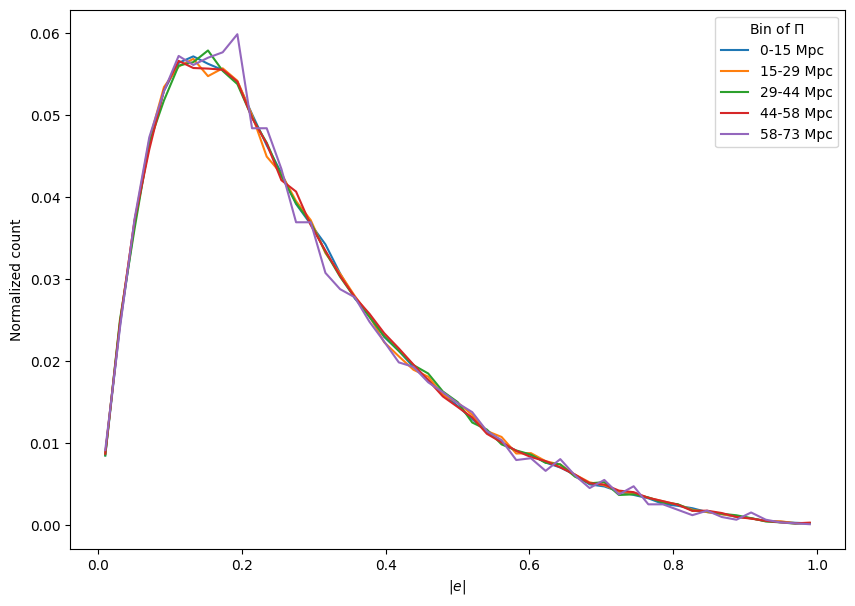

In [148]:
# Définition des bins de pi
pi_bins = np.linspace(0, 350, 25)  # ajustable selon ton besoin
pi_centers = (pi_bins[:-1] + pi_bins[1:]) / 2

# Bins pour l'ellipticité
e_bins = np.linspace(0, 1, 50)
e_cents = (e_bins[1:] + e_bins[:-1]) / 2

sum_ecounts=[]
rp_min=0.1 ; rp_max=10
plt.figure(figsize = (10,7))

for i in range(len(pi_bins) - 1):
    pi_min = pi_bins[i]
    pi_max = pi_bins[i+1]

    # Sélection des paires dans ce bin de pi (on suppose que pi est en colonne 3)
    in_bin = (pairs[:,3] >= pi_min) & (pairs[:,3] < pi_max) & (pairs[:,2] >= rp_min) & (pairs[:,2] < rp_max)
    pair_indices = pairs[in_bin][:, :2].astype(int)

    if len(pair_indices) == 0:
        continue  # on saute si aucune paire

    # Extraire les indices uniques des galaxies concernées
    galaxy_indices = np.unique(pair_indices.flatten())

    # Calcul de l’ellipticité
    e1_values = unions_lrg['e1'].values[galaxy_indices]
    e2_values = unions_lrg['e2'].values[galaxy_indices]

    a_vals, b_vals = np.vectorize(a_b)(e1_values, e2_values)
    theta_vals = np.vectorize(get_galaxy_orientation_angle)(e1_values, e2_values)
    e1_vals, e2_vals = np.vectorize(e_complex)(a_vals, b_vals, theta_vals)
    e_vals = np.vectorize(abs_e)(e1_vals, e2_vals)

    # Histogramme de e
    e_counts, _ = np.histogram(e_vals, bins=e_bins)
    p_e = e_counts / np.sum(e_counts)  # normalisation

    sum_ecounts.append(np.sum(e_counts))

    plt.plot(e_cents, p_e, label=f'{pi_min:.0f}-{pi_max:.0f} Mpc')


sum_ecounts=np.array(sum_ecounts)

plt.xlabel(r"$\vert e \vert$")
plt.ylabel("Normalized count")
plt.legend(title='Bin of $\Pi$')

In [57]:
def get_proj_dist_abacus(cat1, cat2, pos_obs=np.asarray([-3700, 0, 0])*.7):
    '''
    Returns transverse projected distance of two cartesian positions given observer position. 
    Input:
        cat1: astropy table with keys 'x_L2com', 'y_L2com', 'z_L2com'
        cat2: astropy table with keys 'x_L2com', 'y_L2com', 'z_L2com'
        pos_obs: cartesian position of observer. default is [-3700, 0, 0] Mpc/h
    returns in same units as given. default is Mpc/h
    '''
    pos_diff = cat2['x_L2com'] - cat1['x_L2com']
    pos_mid = .5 * (cat2['x_L2com'] + cat1['x_L2com'])
    obs_vec = pos_mid - pos_obs
    
    # project separation vector between objects onto LOS vector
    proj = np.sum(pos_diff*obs_vec, axis=1) / np.linalg.norm(obs_vec, axis=1)
    proj_v = (proj[:, np.newaxis] * obs_vec) / np.linalg.norm(obs_vec, axis=1)[:, np.newaxis]

    # subtract this vector from the separation vector
    # magnitude is projected transverse distance
    transverse_v = pos_diff - proj_v
    return np.linalg.norm(transverse_v, axis=1)

In [63]:
get_proj_dist_abacus(haloes_table1[:10000], haloes_table1[10000:20000])

array([ 538.87689989,  545.27674422,  548.77114157, ..., 1308.08080718,
       1329.82851715, 1312.10082396])

In [26]:
def get_pair_distances(catalog, indices, pos_obs=np.asarray([-3700, 0, 0])*.7, cartesian=False, use_RSD=True):
    '''
    Calculate distances between input pairs, coordinates in Mpc/h
    -------------------------------------------------------------
    Input:
        catalog: astropy table with keys 'x_L2com', 'y_L2com', 'z_L2com'
        indices: array of indices for n centers and maximum m neighbors each- shape(n,m)
        corresponding to place in catalog
    Returns (for cartesian=False):        
        r_projected: projected distance between centers and neighbors
        r_parallel: LOS distance between centers and neighbors
        s_parallel: LOS distance between centers and neighbors, with RSD
    Returns (for cartesian=True):
        deltax: x distance between centers and neighbors    
        deltayz: yz distance between centers and neighbors
    '''
    # indices in catalog of centers and neighbors, arranges so each array is same shape
    ci = np.repeat(indices[:,0], (len(indices[0])-1)).ravel() # indices of centers
    ni = indices[:,1:].ravel()   # indices of neighbors
    
    # removing places where no neighbor was found in the tree
    neighbor_exists = (ni!=len(catalog))
    ci = ci[neighbor_exists]; ni = ni[neighbor_exists]
    
    centers_m = catalog[ci]
    neighbors_m = catalog[ni]   # excluding the centers
    
    if cartesian==False:
        r_projected = get_proj_dist_abacus(centers_m, neighbors_m, pos_obs)

        if use_RSD == False:
            r_parallel = (np.abs(cosmo.comoving_distance(centers_m['Z']) - cosmo.comoving_distance(neighbors_m['Z'])) * 0.7 / u.Mpc).value
            return r_projected, r_parallel
        else:
            r_parallel = (np.abs(cosmo.comoving_distance(centers_m['Z_noRSD']) - cosmo.comoving_distance(neighbors_m['Z_noRSD'])) * 0.7 / u.Mpc).value
            s_parallel = (np.abs(cosmo.comoving_distance(centers_m['Z_withRSD']) - cosmo.comoving_distance(neighbors_m['Z_withRSD'])) * 0.7 / u.Mpc).value
            return r_projected, r_parallel, s_parallel
    
    elif cartesian==True:
        deltax = np.abs(centers_m['x_L2com'][::,0] - neighbors_m['x_L2com'][::,0])
        deltayz = np.sqrt((centers_m['x_L2com'][::,1] - neighbors_m['x_L2com'][::,1])**2 + (centers_m['x_L2com'][::,2] - neighbors_m['x_L2com'][::,2])**2)
        return deltax, deltayz

In [25]:
def generate_IA_pairs(abacus_catalog, save_name, max_los_dist=15, max_proj_dist=350, max_neighbors=6400, overwrite=True, n_batches=10):
    '''assumes galaxies are in a light cone centered on RA=0, DEC=0, z=0.8'''
    
    batch_name = save_name+"_batch"+str(n_batches)+'.fits'
    if overwrite==False:
        # check if file exists
        if os.path.exists(batch_name):
            print('Files exist for all batches, exiting ')
            return None
            
    # make tree of entire catalog
    tree = cKDTree(abacus_catalog['x_L2com'])
    
    # drawing centers from area well with uniform survey geometry
    abacus_centers = abacus_catalog[(
        (abacus_catalog['Z_noRSD'] < 1.3) &  # used to be just "Z", .95
        (abacus_catalog['Z_noRSD'] > 0.7) &   # .58
        (np.abs(abacus_catalog['RA'])<10) & 
        (np.abs(abacus_catalog['DEC'])<10))]
    # randomize order or abacus_centers
    abacus_centers = abacus_centers[np.random.RandomState(seed=42).permutation(len(abacus_centers))]
    
    dist_upper_bound = np.sqrt(max_los_dist**2 + max_proj_dist**2) + 20 # adding a bit to make sure include ones smeared from FOG
    
    for i in range(n_batches):
        batch_name = save_name+"_batch"+str(i)+'.fits'
        if overwrite==False:
            # check if file exists
            if os.path.exists(batch_name):
                continue
            
        center_batch = abacus_centers[i*len(abacus_centers)//n_batches:(i+1)*len(abacus_centers)//n_batches]
        
        # find pairs
        dd, ii = tree.query(center_batch['x_L2com'], distance_upper_bound = dist_upper_bound, k=max_neighbors)
        
        # calculate separations relative to LOS
        r_projected, r_parallel, s_parallel = get_pair_distances(abacus_catalog, ii)
        
        pair_results = Table()
        pair_results['r_p'] = r_projected
        pair_results['r_par'] = r_parallel 
        pair_results['s_par'] = s_parallel
        
        e1_re = get_rel_es(abacus_catalog, ii)
        pair_results['e1_rel'] = e1_re[0]
        
        # cylindrical cut down to relevant pairs
        ii_keep = ((pair_results['r_p']<max_proj_dist)&(pair_results['r_par']<max_los_dist))
        pair_results = pair_results[ii_keep]  ### to improve code, this cut should be done before calculating s_par and e1_rel
        
        pair_results.write(batch_name, overwrite=overwrite)
    
    return None

In [17]:
generate_IA_pairs(haloes_table1, "pairs")

KeyError: 'Z_noRSD'

In [ ]:
e_bins=np.linspace(0,1,50)

nb_rp_bins = len(rp_bins) - 1
nb_pi_bins = len(pi_bins) - 1
nb_e_bins = len(e_bins) - 1

# Initialiser le tableau 3D [rp_bin, pi_bin, e_bin]
e_count_lrg = np.zeros((nb_rp_bins, nb_pi_bins, nb_e_bins), dtype=int)

# Pour chaque paire valide, on regarde les deux galaxies et on ajoute leur e_lrg
for (i_pair, (i, j)) in enumerate(selected_pairs):
    rp_idx, pi_idx = selected_bins[i_pair]

    # Récupère les e des deux galaxies de la paire
    e1_values1 = unions_lrg['e1'][i] ; e2_values1 = unions_lrg['e2'][j]
    a, b = np.vectorize(a_b)(e1_values1, e2_values1)
    theta = np.vectorize(get_galaxy_orientation_angle)(e1_values1, e2_values1)
    e1, e2 = np.vectorize(e_complex)(a, b, theta)
    e_cmass1 = np.vectorize(abs_e)(e1cmass, e2cmass)

    e1_values2 = unions_lrg['e1'][i] ; e2_values2 = unions_lrg['e2'][j]

    





    # On peut ajouter les deux valeurs dans l'histogramme
    e_vals = np.array([e1_values1, e2])
    hist, _ = np.histogram(e_vals, bins=e_bins)

    # Ajoute au compteur du bin correspondant
    e_count_lrg[rp_idx, pi_idx] += hist

In [61]:
print(pairs_in_bin)

[[290403 290675]
 [290981 291006]
 [288871 288884]
 ...
 [  3869   3882]
 [  2737   2743]
 [   233    237]]


In [17]:
pairs = []
for i, neighbors in enumerate(indices):
    for j in neighbors:
        if j > i:
            dx = positions[i] - positions[j]
            r = np.linalg.norm(dx)
            los_sep = np.abs(z_comoving[i] - z_comoving[j])
            trans_sep = np.sqrt(r**2 - los_sep**2)
            pairs.append((i, j, trans_sep, los_sep))

NameError: name 'z_comoving' is not defined

In [6]:
# Somes functions required for further work

def get_galaxy_orientation_angle(e1,e2):
    return 0.5*np.arctan2(e2,e1)

def abs_e(e1,e2):
    return np.sqrt(e1*e1+e2*e2)

def a_b(e1,e2):
    e = abs_e(e1,e2)
    return 1+e,1-e  

def e_complex(a,b,r):
    abs_e = (1-(b/a)) / (1+(b/a))
    e1 = abs_e*np.cos(2*r)
    e2 = abs_e*np.sin(2*r)
    return e1, e2

In [7]:
a = np.zeros(len(selected_galaxies1))
b = np.zeros(len(selected_galaxies1))
theta = np.zeros(len(selected_galaxies1))
axis_ratio_cmass = np.zeros(len(selected_galaxies1))
e1cmass = np.zeros(len(selected_galaxies1))
e2cmass = np.zeros(len(selected_galaxies1))
ecmass = np.zeros(len(selected_galaxies1))

e1_values = selected_galaxies1['e1'][selected_galaxies1_index]
e2_values = selected_galaxies1['e2'][selected_galaxies1_index]

a, b = np.vectorize(a_b)(e1_values, e2_values)
axis_ratio_cmass = a / b

theta = np.vectorize(get_galaxy_orientation_angle)(e1_values, e2_values)
e1cmass, e2cmass = np.vectorize(e_complex)(a, b, theta)

e_cmass1 = np.vectorize(abs_e)(e1cmass, e2cmass)

In [8]:
a = np.zeros(len(selected_galaxies2))
b = np.zeros(len(selected_galaxies2))
theta = np.zeros(len(selected_galaxies2))
axis_ratio_cmass = np.zeros(len(selected_galaxies2))
e1cmass = np.zeros(len(selected_galaxies2))
e2cmass = np.zeros(len(selected_galaxies2))
ecmass = np.zeros(len(selected_galaxies2))

e1_values = selected_galaxies2['e1'][selected_galaxies2_index]
e2_values = selected_galaxies2['e2'][selected_galaxies2_index]

a, b = np.vectorize(a_b)(e1_values, e2_values)
axis_ratio_cmass = a / b

theta = np.vectorize(get_galaxy_orientation_angle)(e1_values, e2_values)
e1cmass, e2cmass = np.vectorize(e_complex)(a, b, theta)

e_cmass2 = np.vectorize(abs_e)(e1cmass, e2cmass)

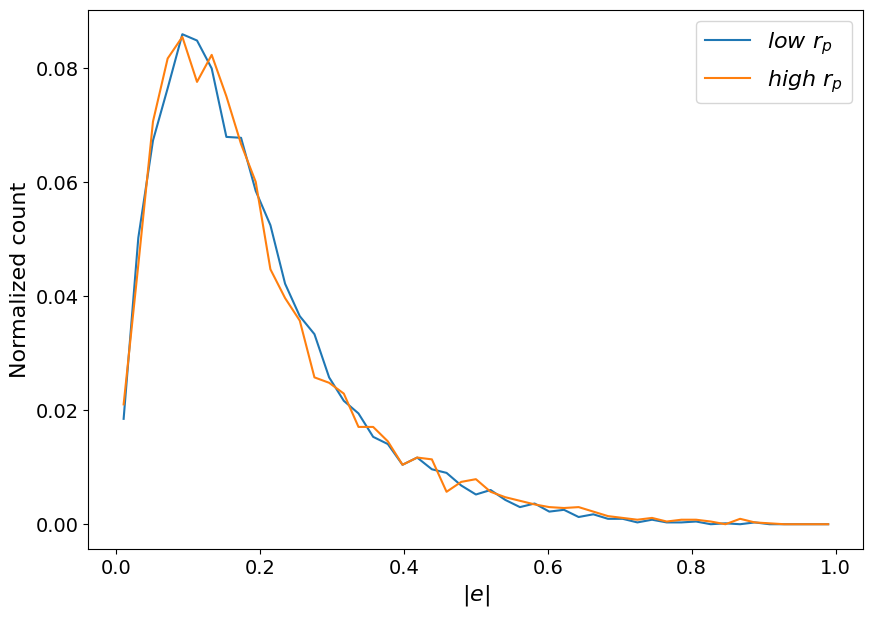

In [9]:
e_bins=np.linspace(0,1,50)
e_cents = (e_bins[1:]+e_bins[:-1])/2.

e_data_counts_cmass1,_ = np.histogram(e_cmass1, bins = e_bins) 
e_data_counts_cmass2,_ = np.histogram(e_cmass2, bins = e_bins) 


plt.figure( figsize = (10,7))
plt.plot(e_cents, e_data_counts_cmass1/nb_unions_cmass1, label=r"$low~r_p$")
plt.plot(e_cents, e_data_counts_cmass2/nb_unions_cmass2, label=r"$high~r_p$")

# plt.errorbar(e_cents, e_data_counts_cmass1/nb_unions_cmass1, yerr=np.sqrt(e_data_counts_cmass) / nb_unions_cmass, label="CMASS-UNIONS", capsize=5)
# plt.errorbar(e_cents, e_data_counts_cmass2/nb_unions_cmass2, yerr=np.sqrt(e_data_counts_elg) / nb_unions_elg, label="ELG-UNIONS", capsize=5)
plt.legend(fontsize=16)
plt.xlabel(r"$\vert e \vert$", fontsize=16)
plt.ylabel("Normalized count", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

In [22]:
# Computation of the wg+ signal for CMASS-UNIONS (reference : https://arxiv.org/pdf/2412.01790)

nrp = 21 ; npi = 51

shape_cat = treecorr.Catalog(x=x_u,y=y_u,z=z_u,g1=e1_u,g2=e2_u)

pi = np.linspace(-15,15,npi)

xi_gp = [] ; xi_gc = [] ; rp=[] ; var = [] ; covar = []
xi_gp=list(xi_gp) ; xi_gc = list (xi_gc) ; rp = list(rp) ; var = list(var) ; covar = list(covar)

for i in np.arange(0, npi-1):
    ng = treecorr.NGCorrelation(nbins=nrp,min_sep = 0.1,max_sep = 350.,min_rpar = pi[i],max_rpar = pi[i+1],bin_type='Log')
    ng.process(shape_cat, shape_cat, metric ='Rperp')
    xi, xi_im, varxi = ng.calculateXi(rg=None) ; r = ng.logr ; cov = ng.cov
    xi_gp.append(xi); xi_gc.append(xi_im); rp.append(r); var.append(varxi) ; covar.append(cov)
    
xi_gp=np.array(xi_gp); xi_gc=np.array(xi_gc); rp_unions=np.array(rp); var=np.array(var) ; covar=np.array(covar)

wgp_unions = np.zeros(nrp) ; wgc_unions = np.zeros(nrp) ; var2 = np.zeros(nrp)
for i in range (nrp):
    wgp_unions[i] = abs(np.sum(xi_gp[:,i]))
    wgc_unions[i] = abs(np.sum(xi_gc[:,i]))
    var2[i] = np.sum(var[:,i])

sigma_unions = np.sqrt(var2)

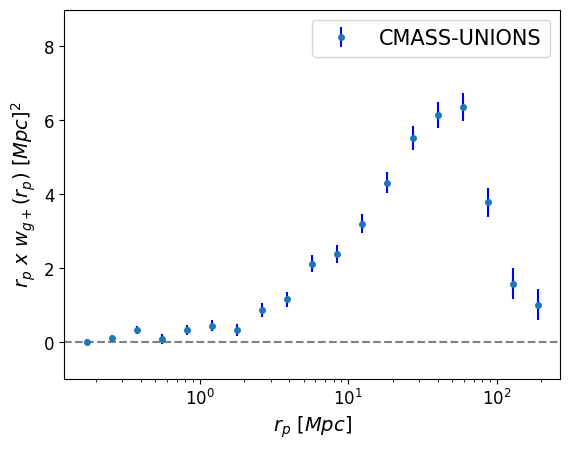

In [23]:
# Plot of the wg+ signal

plt.errorbar(np.exp(rp_unions[0,:len(wgp_unions)-2])/0.7,np.exp(rp_unions[0,:len(wgp_unions)-2])/0.7**2*wgp_unions[:len(wgp_unions)-2],yerr=np.exp(rp_unions[0,:len(wgp_unions)-2])/0.7*sigma_unions[:len(wgp_unions)-2],label='CMASS-UNIONS',
             ecolor='blue',marker='o', markersize = 4,linestyle='None')

plt.xlabel(r"$r_p~[Mpc]$",fontsize=14)
plt.ylabel(r"$r_p~x~w_{g+}(r_p)~[Mpc]^2$",fontsize=14)
plt.ylim(-1,9)
plt.xscale('log')
plt.axhline(0, ls='--', color='grey')
plt.legend(fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig("wg+.pdf")

In [12]:
# Computation of the w++ signal for CMASS-UNIONS

nrp = 21 ; npi = 51

shape_cat = treecorr.Catalog(x=x_u,y=y_u,z=z_u,g1=e1_u,g2=e2_u)

pi = np.linspace(-15,15,npi)

xi_pp = [] ; rp=[] ; var = []
xi_pp = list(xi_pp) ; rp = list(rp) ; var = list(var)

for i in np.arange(0, npi-1):
    gg = treecorr.GGCorrelation(nbins=nrp,min_sep = 0.1,max_sep = 350.,min_rpar = pi[i],max_rpar = pi[i+1],bin_type='Log')
    gg.process(shape_cat, shape_cat, metric ='Rperp')
    xip = gg.xip ; varxi = gg.varxip ; r = ng.logr
    xi_pp.append(xip) ; var.append(varxi); rp.append(r) 
    
xi_pp=np.array(xi_pp) ; var=np.array(var) ; rp_unions=np.array(rp)

wpp_unions = np.zeros(nrp) ; var2 = np.zeros(nrp)
for i in range (nrp):
    wpp_unions[i] = abs(np.sum(xi_pp[:,i]))
    var2[i] = np.sum(var[:,i])

sigma_unions_pp = np.sqrt(var2)

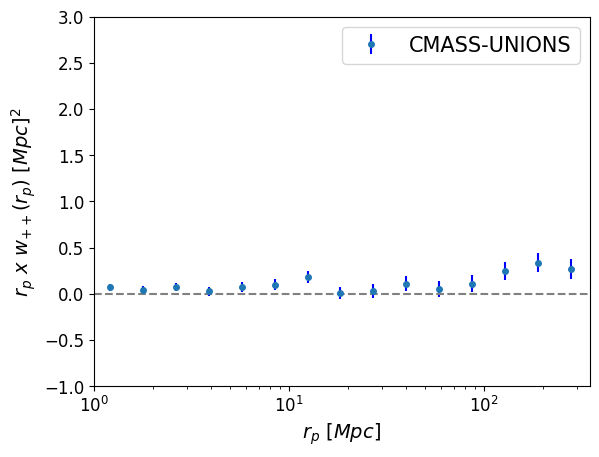

In [18]:
plt.errorbar(np.exp(rp_unions[0,:])/0.7, np.exp(rp_unions[0,:])/0.7**2*wpp_unions, yerr=np.exp(rp_unions[0,:])/0.7*sigma_unions_pp, label='CMASS-UNIONS', ecolor='blue', marker='o',
             markersize = 4, linestyle='None')

plt.xlabel(r"$r_p~[Mpc]$",fontsize=14)
plt.ylabel(r"$r_p~x~w_{++}(r_p)~[Mpc]^2$",fontsize=14)
plt.xscale('log')
plt.xlim(1,350)
plt.ylim(-1,3)
plt.axhline(0, ls='--', color='grey')
plt.legend(fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig("w++.pdf")